In [2]:
import pandas as pd

# Load the dataset
file_path = "acp_ks_full_data2.csv"
df = pd.read_csv(file_path)

# Display first few rows
print(" First 5 rows:")
print(df.head())

# Show all column names
print("\n Columns:")
print(df.columns.tolist())

# Check data types and missing values
print("\n Data types and missing values:")
print(df.info())


 First 5 rows:
         BGC ID   Gene  Module Domain      Location  \
0  BGC0000001.5  abyA3       0    ACP       9-73 AA   
1  BGC0000001.5  abyB1       1     KS      7-415 AA   
2  BGC0000001.5  abyB1       1    ACP    866-937 AA   
3  BGC0000001.5  abyB1       2     KS   956-1378 AA   
4  BGC0000001.5  abyB1       2    ACP  2443-2521 AA   

                                         AA Sequence  \
0  FVTLVRDELGLPIEESDLDRHLDDVAGWDSVHLLALCSALERATGR...   
1  VAVVGLACRLPGAADPEAFWALLRDGREAITDPPASRRDPDGRARR...   
2  LDLVRTAVAVAHGRVGPAAIDPDTTFRDLGLDSVTSVEFRDRLAAA...   
3  VAVIGMACRYPGGVGSPDDLWQLVRDGRDATGPFPTDRGWDLDALY...   
4  PRDEAELREVVRSVVAEVLGYPSAAGVDSARPFRDLGLDSLGGVEL...   

                                         NT Sequence  
0  TTCGTCACCCTGGTCCGCGACGAGCTTGGGCTGCCCATCGAGGAGA...  
1  GTCGCCGTCGTCGGTCTGGCCTGCCGGCTGCCCGGCGCCGCCGATC...  
2  CTCGACCTGGTGCGTACCGCCGTCGCGGTCGCCCACGGCCGCGTCG...  
3  GTAGCCGTCATCGGCATGGCCTGCCGGTACCCCGGCGGGGTCGGCT...  
4  CCGCGTGACGAGGCCGAACTGCGGGAGGTGGTCCGTTCG

In [3]:
pair_rows = []

# Loop through each BGC
for bgc_id, group in df.groupby('BGC ID'):
    # Separate ACP and KS domains
    acps = group[group['Domain'] == 'ACP']
    kss = group[group['Domain'] == 'KS']
    
    # Create pairwise combinations
    for _, acp_row in acps.iterrows():
        for _, ks_row in kss.iterrows():
            label = None
            if acp_row['Gene'] == ks_row['Gene'] and acp_row['Module'] == ks_row['Module']:
                label = 0  # Same gene and same module
            elif acp_row['Gene'] == ks_row['Gene']:
                label = 1  # Same gene but different module
            else:
                label = 2  # Different genes

            pair_rows.append({
                'BGC ID': bgc_id,
                'ACP Gene': acp_row['Gene'],
                'ACP Module': acp_row['Module'],
                'ACP Sequence': acp_row['AA Sequence'],
                'KS Gene': ks_row['Gene'],
                'KS Module': ks_row['Module'],
                'KS Sequence': ks_row['AA Sequence'],
                'Label': label
            })

# Convert to DataFrame
pair_df = pd.DataFrame(pair_rows)

# Preview
print(" ACP–KS Pair Data (first 20 rows):")
print(pair_df.head(20))
print("\nClass distribution:")
print(pair_df['Label'].value_counts())


 ACP–KS Pair Data (first 20 rows):
          BGC ID ACP Gene  ACP Module  \
0   BGC0000001.5    abyA3           0   
1   BGC0000001.5    abyA3           0   
2   BGC0000001.5    abyA3           0   
3   BGC0000001.5    abyA3           0   
4   BGC0000001.5    abyA3           0   
5   BGC0000001.5    abyA3           0   
6   BGC0000001.5    abyA3           0   
7   BGC0000001.5    abyB1           1   
8   BGC0000001.5    abyB1           1   
9   BGC0000001.5    abyB1           1   
10  BGC0000001.5    abyB1           1   
11  BGC0000001.5    abyB1           1   
12  BGC0000001.5    abyB1           1   
13  BGC0000001.5    abyB1           1   
14  BGC0000001.5    abyB1           2   
15  BGC0000001.5    abyB1           2   
16  BGC0000001.5    abyB1           2   
17  BGC0000001.5    abyB1           2   
18  BGC0000001.5    abyB1           2   
19  BGC0000001.5    abyB1           2   

                                         ACP Sequence KS Gene  KS Module  \
0   FVTLVRDELGLPIEESDLDRHLD

In [4]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
from tqdm import tqdm

def extract_features(seq):
    try:
        analysis = ProteinAnalysis(seq.replace("*", "").upper())
        return {
            'mw': analysis.molecular_weight(),
            'pI': analysis.isoelectric_point(),
            'aromaticity': analysis.aromaticity(),
            'instability': analysis.instability_index(),
            'gravy': analysis.gravy(),
            'helix': analysis.secondary_structure_fraction()[0],
            'turn': analysis.secondary_structure_fraction()[1],
            'sheet': analysis.secondary_structure_fraction()[2]
        }
    except:
        return {k: np.nan for k in ['mw', 'pI', 'aromaticity', 'instability', 'gravy', 'helix', 'turn', 'sheet']}

# Apply to both ACP and KS sequences
tqdm.pandas(desc=" Extracting ACP features")
acp_features = pair_df['ACP Sequence'].progress_apply(extract_features).apply(pd.Series)
acp_features.columns = ['acp_' + col for col in acp_features.columns]

tqdm.pandas(desc=" Extracting KS features")
ks_features = pair_df['KS Sequence'].progress_apply(extract_features).apply(pd.Series)
ks_features.columns = ['ks_' + col for col in ks_features.columns]

# Combine features
pair_df_features = pd.concat([pair_df, acp_features, ks_features], axis=1)

# Save for safety
pair_df_features.to_csv("acp_ks_pairs_with_features.csv", index=False)

# Preview
pair_df_features.head()


 Extracting KS features: 100%|██████████| 31201/31201 [00:29<00:00, 1052.13it/s]


BGC ID ACP Gene  ACP Module  \
0  BGC0000001.5    abyA3           0   
1  BGC0000001.5    abyA3           0   
2  BGC0000001.5    abyA3           0   
3  BGC0000001.5    abyA3           0   
4  BGC0000001.5    abyA3           0   

                                        ACP Sequence KS Gene  KS Module  \
0  FVTLVRDELGLPIEESDLDRHLDDVAGWDSVHLLALCSALERATGR...   abyB1          1   
1  FVTLVRDELGLPIEESDLDRHLDDVAGWDSVHLLALCSALERATGR...   abyB1          2   
2  FVTLVRDELGLPIEESDLDRHLDDVAGWDSVHLLALCSALERATGR...   abyB1          3   
3  FVTLVRDELGLPIEESDLDRHLDDVAGWDSVHLLALCSALERATGR...   abyB1          4   
4  FVTLVRDELGLPIEESDLDRHLDDVAGWDSVHLLALCSALERATGR...   abyB2          5   

                                         KS Sequence  Label    acp_mw  \
0  VAVVGLACRLPGAADPEAFWALLRDGREAITDPPASRRDPDGRARR...      2  6834.631   
1  VAVIGMACRYPGGVGSPDDLWQLVRDGRDATGPFPTDRGWDLDALY...      2  6834.631   
2  IAIVGMACRYPGGVSSPEDLWRLVADGVDAIGEFPTDRGWDLGRLY...      2  6834.631   
3  IAIVGMACRYPGGVSSPEDLWRLVADGVDAIGEFPTDRGWGEIHDP...      2  6834.631   
4  VAIVSMACRFPGGVASPEDLWQLVASGTDAISGFPDDRGWPLDELY...      2  6834.631   

     acp_pI  ...  acp_turn  acp_sheet       ks_mw     ks_pI  ks_aromaticity  \
0  4.295402  ...    0.3125    0.40625  42497.3608  5.571665        0.041667   
1  4.295402  ...    0.3125    0.40625  44010.8354  5.522329        0.054502   
2  4.295402  ...    0.3125    0.40625  44424.9735  5.802829        0.066351   
3  4.295402  ...    0.3125    0.40625  44163.8029  5.801465        0.061466   
4  4.295402  ...    0.3125    0.40625  44198.0466  5.160208        0.059242   

   ks_instability  ks_gravy  ks_helix   ks_turn  ks_sheet  
0       27.585539 -0.030882  0.311275  0.333333  0.335784  
1       28.218483 -0.103081  0.305687  0.319905  0.334123  
2       30.241232 -0.134597  0.279621  0.319905  0.343602  
3       31.368794 -0.125768  0.290780  0.330969  0.326241  
4       37.111848 -0.079621  0.319905  0.319905  0.319905  

[5 rows x 24 columns]

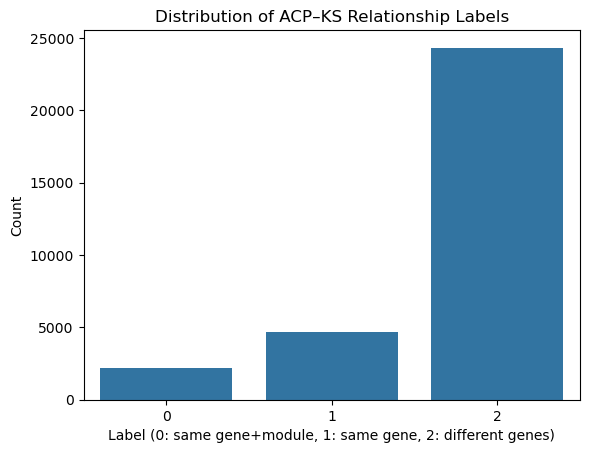

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution
sns.countplot(x='Label', data=pair_df_features)
plt.title("Distribution of ACP–KS Relationship Labels")
plt.xlabel("Label (0: same gene+module, 1: same gene, 2: different genes)")
plt.ylabel("Count")
plt.show()


In [13]:
# Re-define the feature columns (all ACP and KS biochemical features)
feature_cols = [col for col in pair_df_features.columns if col.startswith('acp_') or col.startswith('ks_')]


In [15]:
# Check basic stats of all features
pair_df_features[feature_cols].describe().T


count          mean          std           min  \
acp_mw           31179.0   8131.602243   922.611813   3291.669900   
acp_pI           31179.0      5.428500     1.298425      4.050028   
acp_aromaticity  31179.0      0.062166     0.026015      0.000000   
acp_instability  31179.0     35.650489    11.793123     -1.493590   
acp_gravy        31179.0      0.107967     0.201043     -0.734921   
acp_helix        31179.0      0.387179     0.048573      0.176471   
acp_turn         31179.0      0.251070     0.035102      0.138889   
acp_sheet        31179.0      0.396079     0.039934      0.245192   
ks_mw            31179.0  44336.414911  2176.020405  21340.829800   
ks_pI            31179.0      5.355897     0.478534      4.387595   
ks_aromaticity   31179.0      0.066164     0.012072      0.023460   
ks_instability   31179.0     35.475235     5.073137     19.142043   
ks_gravy         31179.0     -0.074815     0.091064     -0.428638   
ks_helix         31179.0      0.306421     0.019088      0.244186   
ks_turn          31179.0      0.326279     0.015504      0.263043   
ks_sheet         31179.0      0.323428     0.012851      0.265306   

                          25%           50%           75%           max  
acp_mw            7461.349300   7876.759700   9022.074500  20519.095400  
acp_pI               4.587327      5.068356      5.832613     11.881604  
acp_aromaticity      0.043478      0.058140      0.074074      0.192308  
acp_instability     27.473256     34.357471     43.130137     90.746988  
acp_gravy           -0.020000      0.107143      0.243056      0.900000  
acp_helix            0.358025      0.388235      0.419753      0.566667  
acp_turn             0.227273      0.250000      0.273973      0.409091  
acp_sheet            0.369048      0.394366      0.420290      0.527027  
ks_mw            43882.701200  44436.112000  45019.580600  61432.807800  
ks_pI                4.996398      5.254049      5.621570     10.080873  
ks_aromaticity       0.058411      0.063380      0.074341      0.105140  
ks_instability      32.077230     35.143662     38.534404     58.036648  
ks_gravy            -0.131455     -0.074023     -0.019977      0.391837  
ks_helix             0.293427      0.305882      0.318396      0.399351  
ks_turn              0.316667      0.327014      0.336471      0.381517  
ks_sheet             0.314634      0.322353      0.330986      0.373832

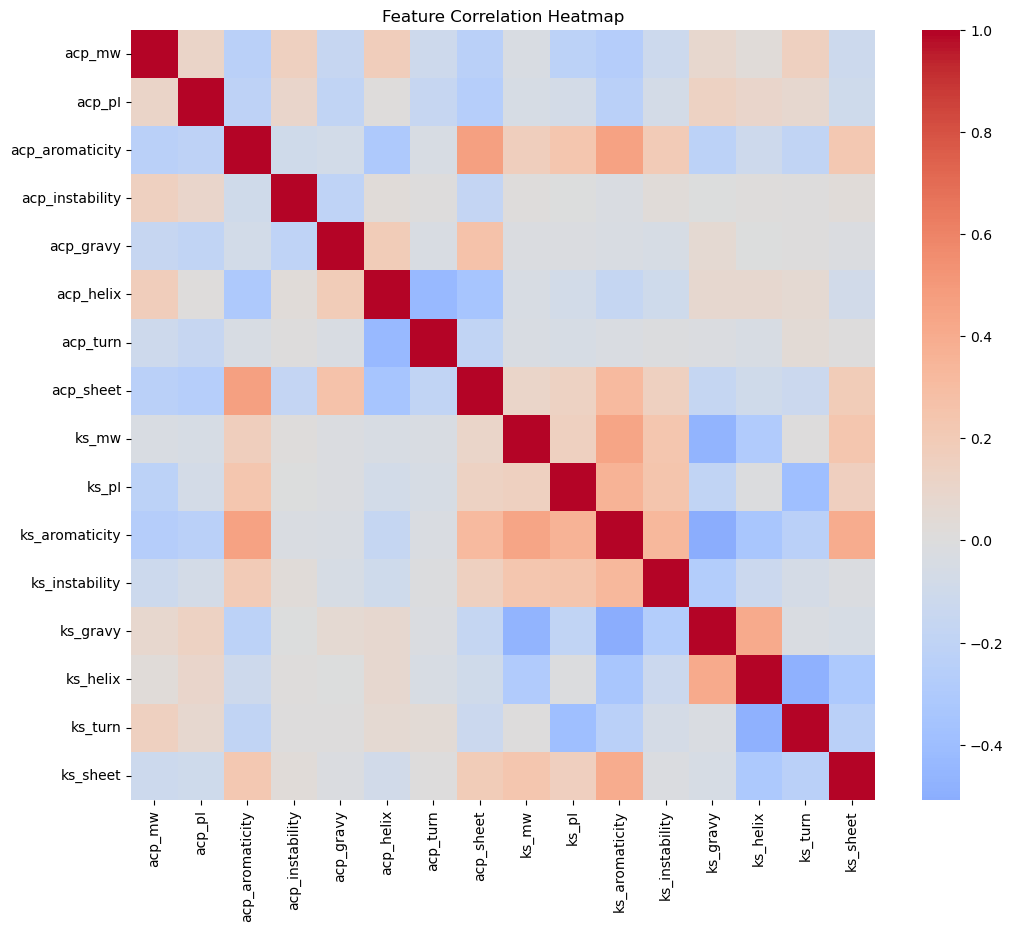

In [17]:
# Correlation matrix
corr = pair_df_features[feature_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


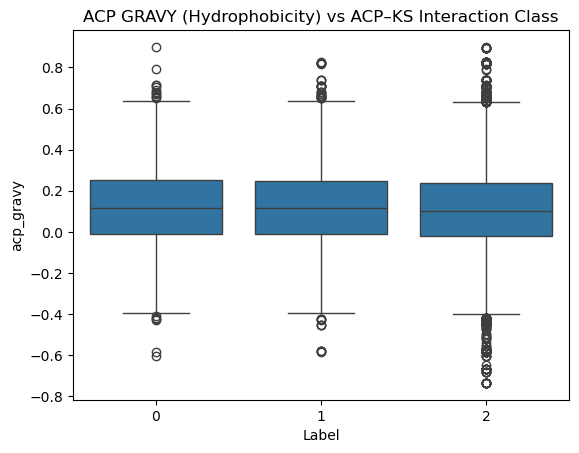

In [19]:
sns.boxplot(x='Label', y='acp_gravy', data=pair_df_features)
plt.title("ACP GRAVY (Hydrophobicity) vs ACP–KS Interaction Class")
plt.show()


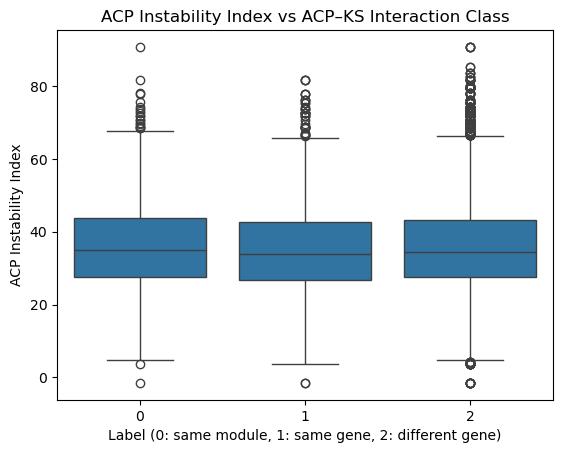

In [21]:
sns.boxplot(x='Label', y='acp_instability', data=pair_df_features)
plt.title("ACP Instability Index vs ACP–KS Interaction Class")
plt.xlabel("Label (0: same module, 1: same gene, 2: different gene)")
plt.ylabel("ACP Instability Index")
plt.show()


In [25]:
from scipy.stats import mannwhitneyu

# Drop NaNs from both classes
gravy_0 = pair_df_features[pair_df_features['Label'] == 0]['acp_gravy'].dropna()
gravy_2 = pair_df_features[pair_df_features['Label'] == 2]['acp_gravy'].dropna()

# Check size first (optional sanity check)
print(f"n(class 0): {len(gravy_0)}, n(class 2): {len(gravy_2)}")

# Run test
stat, p = mannwhitneyu(gravy_0, gravy_2, alternative='two-sided')
print(f"Mann–Whitney U Test between class 0 and class 2 (acp_gravy): U={stat:.2f}, p-value={p:.4f}")


n(class 0): 2189, n(class 2): 24312
Mann–Whitney U Test between class 0 and class 2 (acp_gravy): U=27680271.50, p-value=0.0018


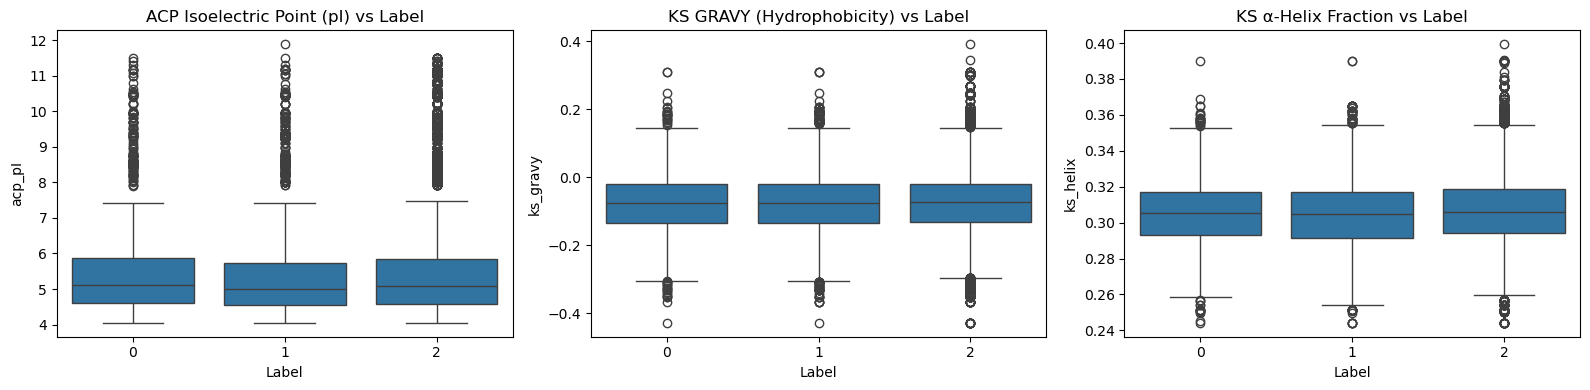

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))

# acp_pI
plt.subplot(1, 3, 1)
sns.boxplot(x='Label', y='acp_pI', data=pair_df_features)
plt.title("ACP Isoelectric Point (pI) vs Label")

# ks_gravy
plt.subplot(1, 3, 2)
sns.boxplot(x='Label', y='ks_gravy', data=pair_df_features)
plt.title("KS GRAVY (Hydrophobicity) vs Label")

# ks_helix
plt.subplot(1, 3, 3)
sns.boxplot(x='Label', y='ks_helix', data=pair_df_features)
plt.title("KS α-Helix Fraction vs Label")

plt.tight_layout()
plt.show()


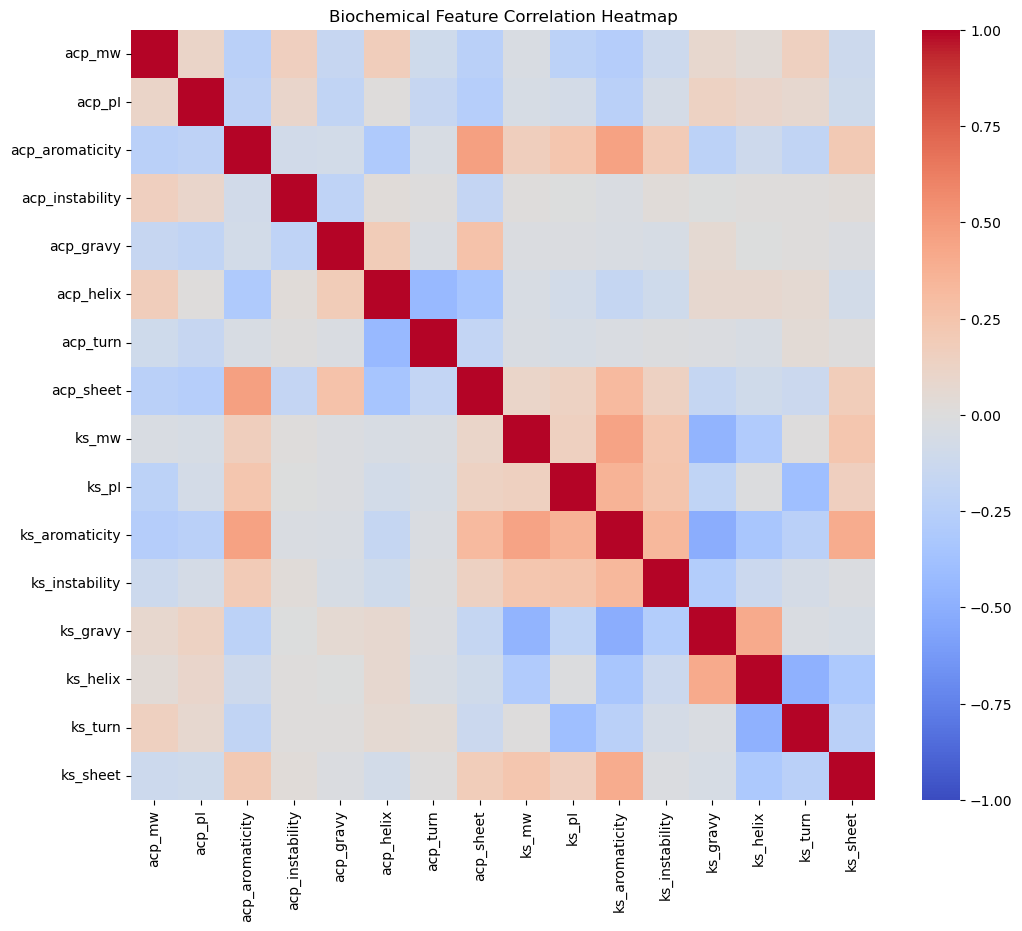

In [29]:
import numpy as np

corr = pair_df_features[feature_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Biochemical Feature Correlation Heatmap")
plt.show()


In [31]:
import re

def extract_serine_region(seq, window=25):
    """
    Find Gx(D/E)S(I/L) motif and extract 25 residues from the serine onward.
    Returns None if motif not found.
    """
    pattern = r'G.(D|E)S(I|L)'
    match = re.search(pattern, seq)
    if match:
        start = match.start() + 2  # serine (S) is the 3rd letter in the motif
        region = seq[start:start+window]
        return region if len(region) == window else None
    return None

# Apply this to ACP sequences
pair_df_features['acp_serine_region'] = pair_df_features['ACP Sequence'].apply(extract_serine_region)

# Check how many were found
n_found = pair_df_features['acp_serine_region'].notnull().sum()
print(f" Serine region extracted from {n_found} / {len(pair_df_features)} ACP sequences")


 Serine region extracted from 23590 / 31201 ACP sequences


In [41]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def extract_serine_features(seq):
    try:
        analysis = ProteinAnalysis(seq.upper())
        return {
            'serine_mw': analysis.molecular_weight(),
            'serine_pI': analysis.isoelectric_point(),
            'serine_aromaticity': analysis.aromaticity(),
            'serine_instability': analysis.instability_index(),
            'serine_gravy': analysis.gravy(),
            'serine_helix': analysis.secondary_structure_fraction()[0],
            'serine_turn': analysis.secondary_structure_fraction()[1],
            'serine_sheet': analysis.secondary_structure_fraction()[2]
        }
    except:
        return {k: None for k in [
            'serine_mw', 'serine_pI', 'serine_aromaticity',
            'serine_instability', 'serine_gravy', 
            'serine_helix', 'serine_turn', 'serine_sheet'
        ]}

# Apply to the serine region
from tqdm import tqdm
tqdm.pandas(desc=" Extracting serine-region features")

serine_features = pair_df_features['acp_serine_region'].progress_apply(extract_serine_features).apply(pd.Series)

# Merge with main DataFrame
pair_df_features = pd.concat([pair_df_features, serine_features], axis=1)


 Extracting serine-region features: 100%|██████████| 31201/31201 [00:07<00:00, 4078.13it/s]


In [45]:
from tqdm import tqdm
tqdm.pandas(desc=" Extracting serine features")

# Redo the feature extraction and expand into separate columns
serine_features = pair_df_features['acp_serine_region'].progress_apply(extract_serine_features).apply(pd.Series)

# Merge correctly 
pair_df_features = pd.concat([pair_df_features.reset_index(drop=True), serine_features.reset_index(drop=True)], axis=1)


 Extracting serine features: 100%|██████████| 31201/31201 [00:07<00:00, 4077.29it/s]


In [51]:
# Remove duplicate columns
pair_df_features = pair_df_features.loc[:, ~pair_df_features.columns.duplicated()]


In [53]:
print(pair_df_features.columns[pair_df_features.columns.str.startswith('serine_')])


Index(['serine_mw', 'serine_pI', 'serine_aromaticity', 'serine_instability',
       'serine_gravy', 'serine_helix', 'serine_turn', 'serine_sheet'],
      dtype='object')


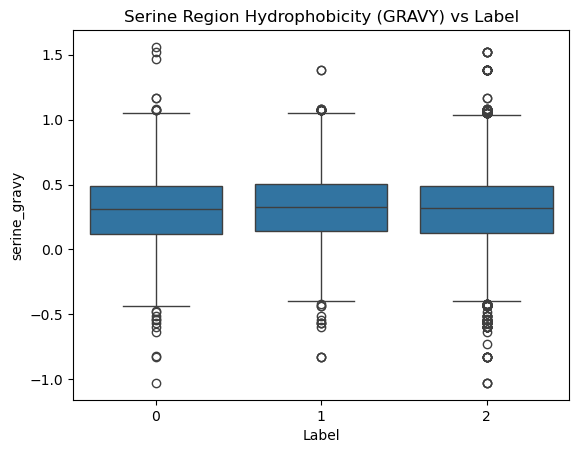

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Label', y='serine_gravy', data=pair_df_features)
plt.title("Serine Region Hydrophobicity (GRAVY) vs Label")
plt.show()


In [59]:
group0 = pair_df_features[pair_df_features['Label'] == 0]['serine_gravy'].dropna()
group2 = pair_df_features[pair_df_features['Label'] == 2]['serine_gravy'].dropna()

print(f"Class 0 (n={len(group0)}), Class 2 (n={len(group2)})")


Class 0 (n=1792), Class 2 (n=18199)


In [61]:
from scipy.stats import mannwhitneyu

group0 = pair_df_features[pair_df_features['Label'] == 0]['serine_gravy'].dropna()
group2 = pair_df_features[pair_df_features['Label'] == 2]['serine_gravy'].dropna()

# Perform Mann-Whitney U test
u_stat, p_value = mannwhitneyu(group0, group2, alternative='two-sided')

print(f"Mann–Whitney U Test (Class 0 vs 2): U={u_stat:.2f}, p-value={p_value:.4f}")


Mann–Whitney U Test (Class 0 vs 2): U=16086993.00, p-value=0.3468


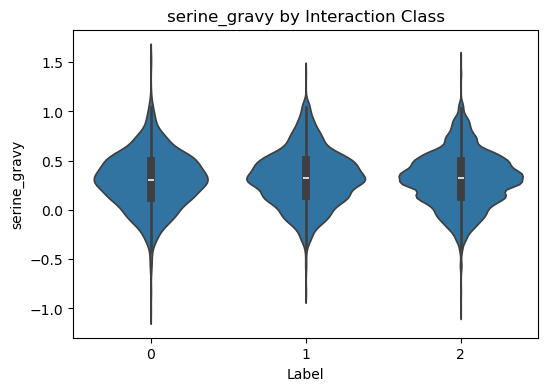

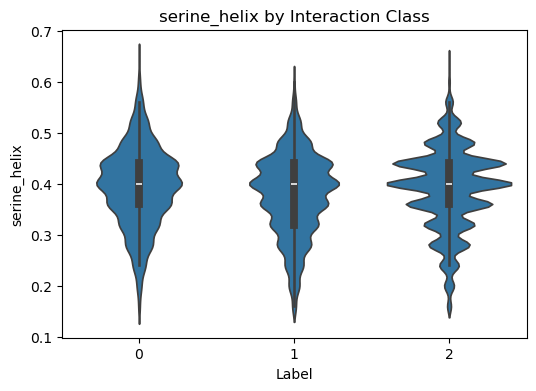

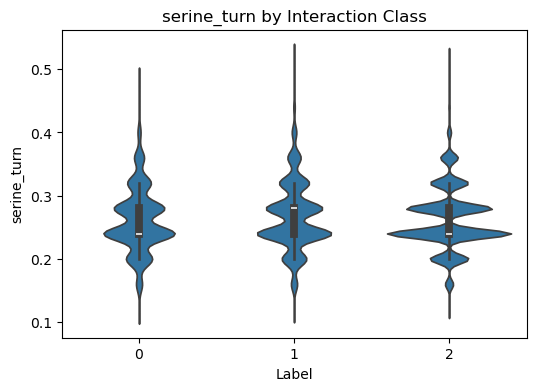

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

for feat in ['serine_gravy', 'serine_helix', 'serine_turn']:
    plt.figure(figsize=(6, 4))
    sns.violinplot(x='Label', y=feat, data=pair_df_features)
    plt.title(f"{feat} by Interaction Class")
    plt.show()


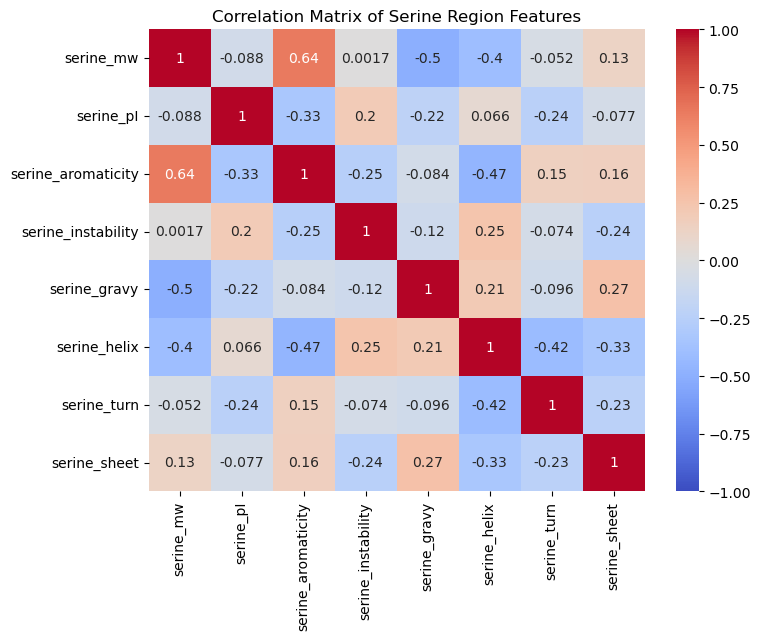

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

#  Select only numeric 'serine_' features
features_to_check = [
    col for col in pair_df_features.columns 
    if 'serine_' in col and pd.api.types.is_numeric_dtype(pair_df_features[col])
]

#  Compute correlation matrix
corr = pair_df_features[features_to_check].corr()

# Step 3: Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Serine Region Features")
plt.show()


In [79]:
# Count unique ACP and KS sequences
num_acp_sequences = pair_df['ACP Sequence'].nunique()
num_ks_sequences = pair_df['KS Sequence'].nunique()

print(f"Unique ACP sequences: {num_acp_sequences}")
print(f"Unique KS sequences: {num_ks_sequences}")
print(f"Total sequences to embed: {num_acp_sequences + num_ks_sequences}")


Unique ACP sequences: 2699
Unique KS sequences: 2453
Total sequences to embed: 5152


In [81]:
serine_cols = [col for col in pair_df_features.columns if 'serine_' in col]


In [83]:
pair_df_features = pair_df_features.dropna(subset=serine_cols)


In [91]:
!pip install transformers
!pip install torch


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [93]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
from tqdm import tqdm

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert")
model = model.eval()


In [95]:
def embed_sequence(seq, tokenizer, model):
    # Add spaces between amino acids
    seq = ' '.join(list(seq))
    tokens = tokenizer(seq, return_tensors='pt', padding=True)
    
    with torch.no_grad():
        output = model(**tokens)
    
    # Use mean of last hidden layer across tokens
    embeddings = output.last_hidden_state.squeeze(0)[1:-1]  # Exclude [CLS] and [SEP]
    return embeddings.mean(dim=0).numpy()


In [151]:
acp_seqs = pair_df_features['ACP Sequence'].unique()
ks_seqs = pair_df_features['KS Sequence'].unique()

acp_embeddings = {}
ks_embeddings = {}

print("Embedding ACP sequences...")
for seq in tqdm(acp_seqs):
    acp_embeddings[seq] = embed_sequence(seq, tokenizer, model)

print("Embedding KS sequences...")
for seq in tqdm(ks_seqs):
    ks_embeddings[seq] = embed_sequence(seq, tokenizer, model)


Embedding ACP sequences...


100%|██████████| 2699/2699 [22:11<00:00,  2.03it/s]


Embedding KS sequences...


100%|██████████| 2453/2453 [1:45:46<00:00,  2.59s/it]


In [153]:
print("ACP embedding count:", len(acp_embeddings))
print("KS embedding count:", len(ks_embeddings))


ACP embedding count: 2699
KS embedding count: 2453


In [155]:
import pickle

# Save ACP embeddings
with open("acp_embeddings.pkl", "wb") as f:
    pickle.dump(acp_embeddings, f)

# Save KS embeddings
with open("ks_embeddings.pkl", "wb") as f:
    pickle.dump(ks_embeddings, f)


In [157]:
with open("acp_embeddings.pkl", "rb") as f:
    acp_embeddings = pickle.load(f)

with open("ks_embeddings.pkl", "rb") as f:
    ks_embeddings = pickle.load(f)

print("ACP embeddings loaded:", len(acp_embeddings))
print("KS embeddings loaded:", len(ks_embeddings))


ACP embeddings loaded: 2699
KS embeddings loaded: 2453


In [159]:
pair_df_features = pair_df.copy()

# Add embeddings to the dataframe
pair_df_features['acp_emb'] = pair_df_features['ACP Sequence'].map(acp_embeddings)
pair_df_features['ks_emb'] = pair_df_features['KS Sequence'].map(ks_embeddings)

# Check missing
print("Missing ACP:", pair_df_features['acp_emb'].isna().sum())
print("Missing KS:", pair_df_features['ks_emb'].isna().sum())


Missing ACP: 0
Missing KS: 0


In [161]:
import numpy as np

# Identify serine-related feature columns
serine_cols = [col for col in pair_df_features.columns if col.startswith("serine_")]

# Define a function to combine all features into one array
def combine_features(row):
    acp = row['acp_emb']
    ks = row['ks_emb']
    serine = row[serine_cols].values.astype(np.float32)

    # Check all are valid numpy arrays
    if isinstance(acp, np.ndarray) and isinstance(ks, np.ndarray):
        return np.concatenate([acp, ks, serine])
    else:
        return np.nan

# Apply the function to all rows
pair_df_features['final_features'] = pair_df_features.apply(combine_features, axis=1)

# Drop rows where final_features could not be created
pair_df_features = pair_df_features.dropna(subset=['final_features'])


In [163]:
print("Final shape:", pair_df_features.shape)
print("Example feature vector shape:", pair_df_features['final_features'].iloc[0].shape)


Final shape: (31201, 11)
Example feature vector shape: (2048,)


In [165]:
from sklearn.model_selection import train_test_split

# Extract features and labels
X = np.stack(pair_df_features['final_features'].values)
y = pair_df_features['Label'].values  # or 'label', depending on column name

# Split into train and test (e.g., 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (24960, 2048) (24960,)
Test shape: (6241, 2048) (6241,)


In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Define the model
clf = LogisticRegression(max_iter=1000, random_state=42)

# Train
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.04      0.08       438
           1       0.00      0.00      0.00       936
           2       0.78      1.00      0.88      4867

    accuracy                           0.78      6241
   macro avg       0.52      0.35      0.32      6241
weighted avg       0.66      0.78      0.69      6241

Confusion Matrix:
[[  18    0  420]
 [   2    0  934]
 [   3    0 4864]]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [169]:
import pickle

with open("logistic_model.pkl", "wb") as f:
    pickle.dump(clf, f)


In [171]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))


{0: 1753, 1: 3745, 2: 19462}


In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.42      0.16       438
           1       0.22      0.52      0.31       936
           2       0.85      0.39      0.53      4867

    accuracy                           0.41      6241
   macro avg       0.39      0.44      0.33      6241
weighted avg       0.70      0.41      0.47      6241

Confusion Matrix:
 [[ 182  137  119]
 [ 237  483  216]
 [1429 1558 1880]]


In [176]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.09      0.16       438
           1       0.75      0.08      0.14       936
           2       0.80      1.00      0.89      4867

    accuracy                           0.80      6241
   macro avg       0.82      0.39      0.40      6241
weighted avg       0.80      0.80      0.72      6241

Confusion Matrix:
 [[  38   13  387]
 [   2   73  861]
 [   1   11 4855]]


In [178]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(scale_pos_weight=None, objective='multi:softmax', num_class=3)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.07      0.13       438
           1       0.55      0.14      0.22       936
           2       0.80      0.98      0.88      4867

    accuracy                           0.79      6241
   macro avg       0.70      0.40      0.41      6241
weighted avg       0.76      0.79      0.73      6241

Confusion Matrix:
 [[  32   34  372]
 [   4  127  805]
 [   7   68 4792]]


In [180]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [184]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)


In [186]:
xgb.fit(X_train_res, y_train_res)


C:\Users\karth\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:36:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [188]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = xgb.predict(X_test)

# Print metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.20      0.14       438
           1       0.26      0.41      0.32       936
           2       0.83      0.67      0.74      4867

    accuracy                           0.60      6241
   macro avg       0.40      0.43      0.40      6241
weighted avg       0.70      0.60      0.64      6241

Confusion Matrix:
[[  86  127  225]
 [ 124  387  425]
 [ 618  987 3262]]


In [190]:
pair_df_features['binary_label'] = pair_df_features['Label'].apply(lambda x: 1 if x in [0, 1] else 0)


In [192]:
from sklearn.model_selection import train_test_split

X = pair_df_features['final_features'].tolist()
y = pair_df_features['binary_label'].values

X = np.array(X)  # Ensure it's a NumPy array
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [194]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [196]:
from xgboost import XGBClassifier

xgb_bin = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=5)
xgb_bin.fit(X_train_res, y_train_res)


C:\Users\karth\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:42:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [198]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = xgb_bin.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81      4866
           1       0.37      0.42      0.39      1375

    accuracy                           0.71      6241
   macro avg       0.60      0.61      0.60      6241
weighted avg       0.73      0.71      0.72      6241

Confusion Matrix:
 [[3886  980]
 [ 804  571]]


In [200]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_res, y_train_res)


RandomForestClassifier()

In [202]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred_rf = rf.predict(X_test)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      4866
           1       0.57      0.33      0.41      1375

    accuracy                           0.80      6241
   macro avg       0.70      0.63      0.65      6241
weighted avg       0.77      0.80      0.77      6241

Confusion Matrix:
[[4520  346]
 [ 925  450]]


In [204]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)


In [206]:
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [207]:
y_pred = rf.predict(X_test)


In [218]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity
def compute_cosine_similarity(row):
    return cosine_similarity(
        row['acp_emb'].reshape(1, -1), 
        row['ks_emb'].reshape(1, -1)
    )[0][0]

# Compute cosine similarity for each pair
pair_df_features['cosine_sim'] = pair_df_features.apply(compute_cosine_similarity, axis=1)

# Combine embeddings + cosine similarity into the final feature vector
pair_df_features['pairwise_features'] = pair_df_features.apply(
    lambda row: np.concatenate([row['acp_emb'], row['ks_emb'], [row['cosine_sim']]]),
    axis=1
)

# Continue as before
X = np.vstack(pair_df_features['pairwise_features'].values)
y = pair_df_features['Label'].values

from sklearn.preprocessing import LabelEncoder
if y.dtype == 'O':
    le = LabelEncoder()
    y = le.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

from sklearn.ensemble import RandomForestClassifier
rf_pairwise = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_pairwise.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix
y_pred = rf_pairwise.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")let
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.08      0.15       438
           1       0.74      0.09      0.15       936
           2       0.80      1.00      0.89      4867

    accuracy                           0.80      6241
   macro avg       0.80      0.39      0.40      6241
weighted avg       0.79      0.80      0.72      6241

Confusion Matrix:
[[  36   17  385]
 [   2   81  853]
 [   3   12 4852]]


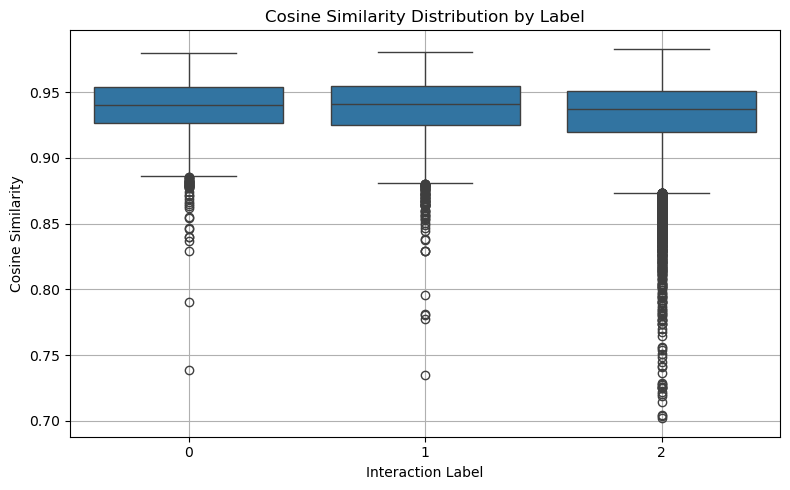

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot cosine similarity grouped by label
plt.figure(figsize=(8, 5))
sns.boxplot(x='Label', y='cosine_sim', data=pair_df_features)
plt.title("Cosine Similarity Distribution by Label")
plt.ylabel("Cosine Similarity")
plt.xlabel("Interaction Label")
plt.grid(True)
plt.tight_layout()
plt.show()


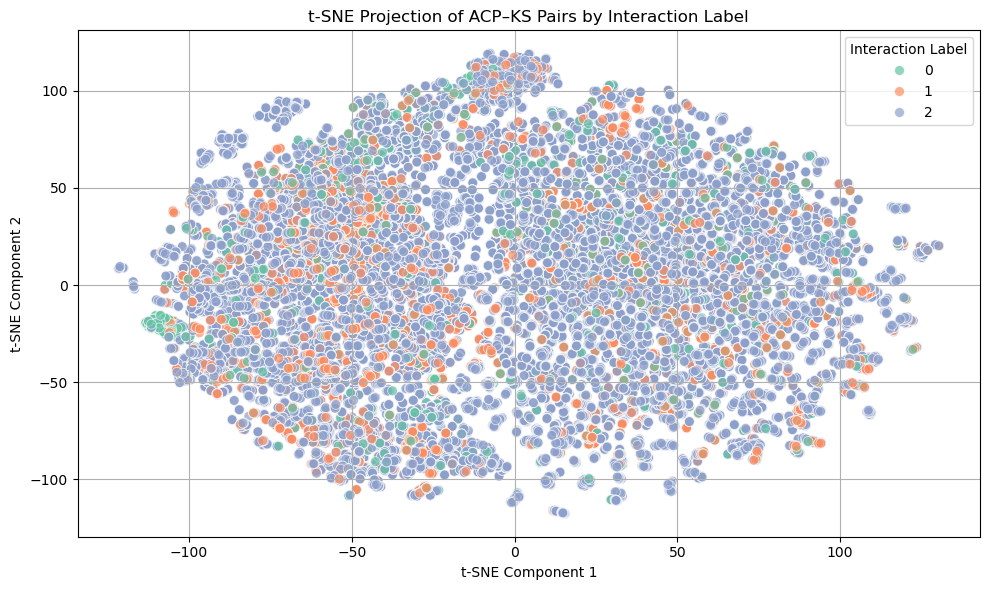

In [228]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Apply t-SNE on the final features (high dimensional to 2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Plot the result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set2', s=50, alpha=0.7)
plt.title("t-SNE Projection of ACP–KS Pairs by Interaction Label")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Interaction Label')
plt.grid(True)
plt.tight_layout()
plt.show()


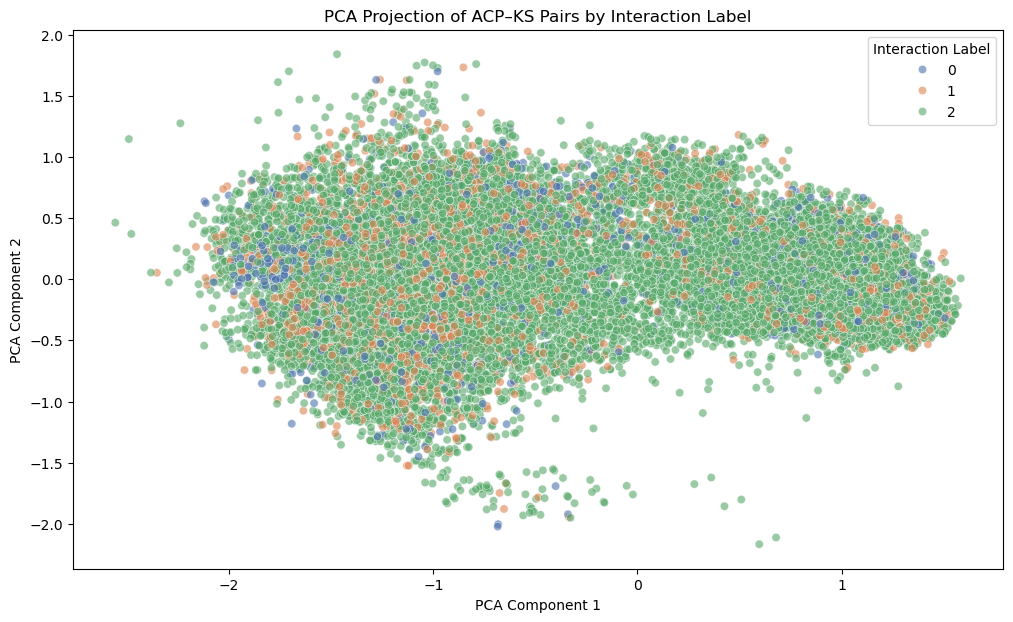

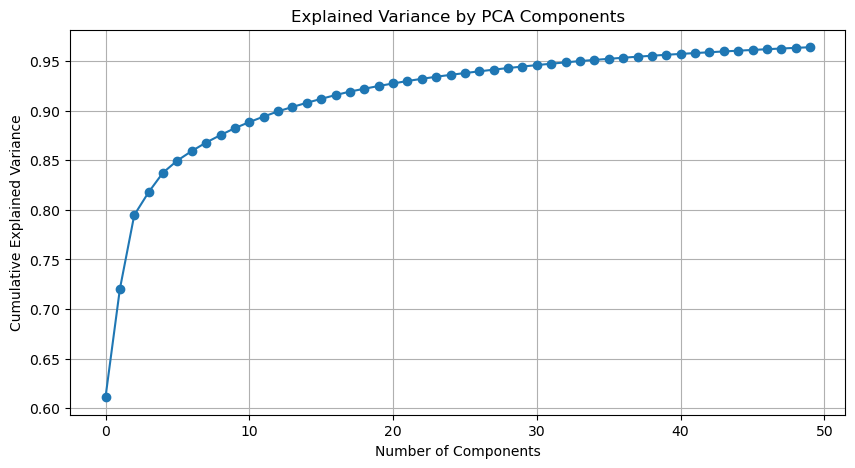

In [230]:
from sklearn.decomposition import PCA

# Step 1: Run PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# Step 2: 2D PCA scatter plot
pca_df = pd.DataFrame(X_pca[:, :2], columns=['PCA1', 'PCA2'])
pca_df['Label'] = y

plt.figure(figsize=(12, 7))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Label', alpha=0.6, palette='deep')
plt.title("PCA Projection of ACP–KS Pairs by Interaction Label")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Interaction Label")
plt.show()

# Step 3: Scree plot (explained variance)
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()


Defaulting to user installation because normal site-packages is not writeable


C:\Users\karth\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


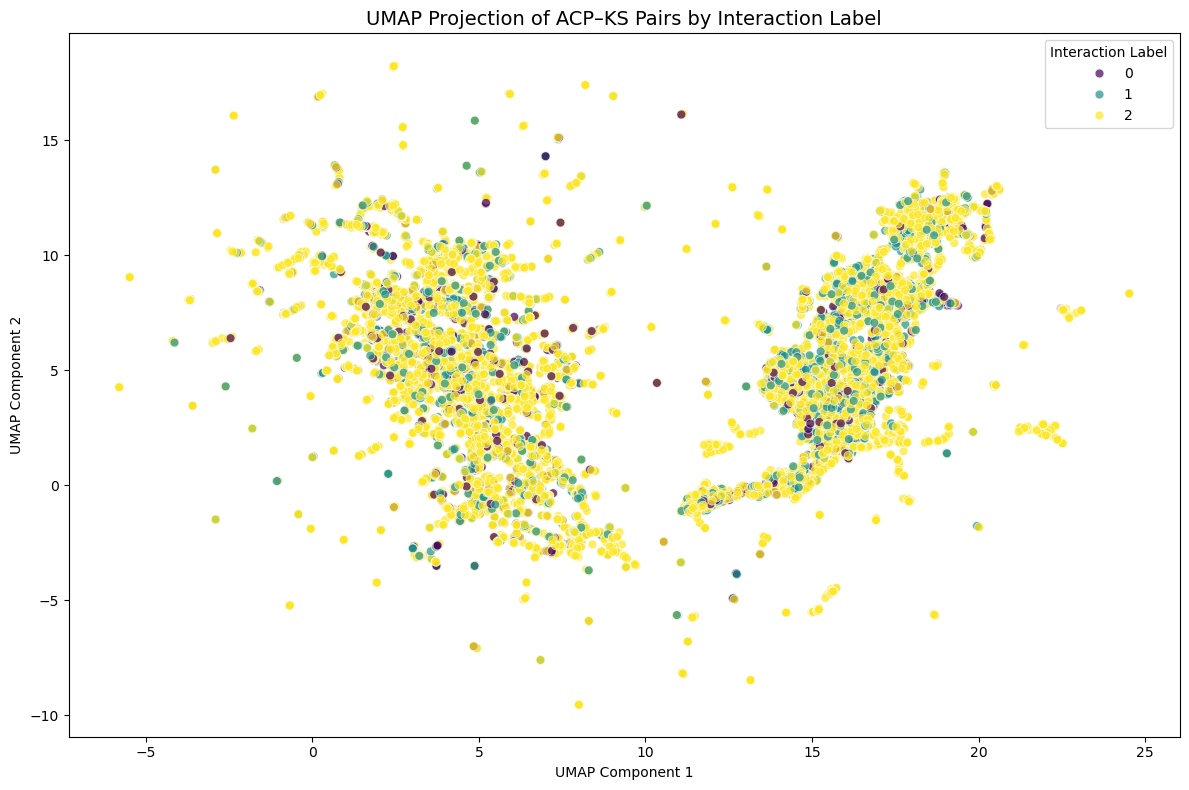

In [284]:
# Install UMAP if not already installed
!pip install umap-learn

import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert X_train to DataFrame if it's still NumPy array
X_train_df = pd.DataFrame(X_train)

# Initialize UMAP reducer
reducer = umap.UMAP(
    n_neighbors=15,      # controls local structure (try 10, 20 for variations)
    min_dist=0.1,        # lower = more clustered, higher = more spread out
    n_components=2,      # we want 2D visualization
    random_state=42
)

# Fit and transform the features into 2D space
umap_embedding = reducer.fit_transform(X_train_df)

# Create a DataFrame for visualization
umap_df = pd.DataFrame({
    'UMAP1': umap_embedding[:, 0],
    'UMAP2': umap_embedding[:, 1],
    'Interaction Label': y_train
})

# Plot UMAP visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="Interaction Label",
    palette="viridis",
    alpha=0.7,
    s=40
)

plt.title("UMAP Projection of ACP–KS Pairs by Interaction Label", fontsize=14)
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title="Interaction Label")
plt.tight_layout()
plt.show()


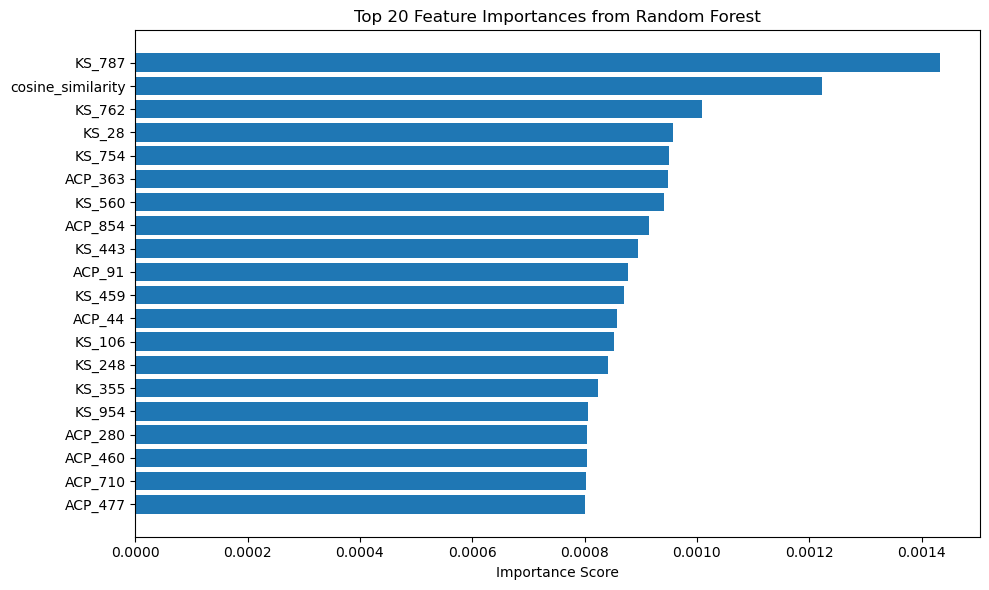

In [232]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained Random Forest
importances = rf_pairwise.feature_importances_

# Total number of features: ACP (1024) + KS (1024) + 1 cosine sim = 2049
acp_dim = pair_df_features['acp_emb'].iloc[0].shape[0]
ks_dim = pair_df_features['ks_emb'].iloc[0].shape[0]

# Create labels for top features only for plotting
feature_labels = (
    [f"ACP_{i}" for i in range(acp_dim)] +
    [f"KS_{i}" for i in range(ks_dim)] +
    ["cosine_similarity"]
)

# Sort by importance
sorted_indices = np.argsort(importances)[::-1]
top_n = 20  # top N features to plot
top_features = [feature_labels[i] for i in sorted_indices[:top_n]]
top_importances = importances[sorted_indices[:top_n]]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances[::-1], align='center')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel('Importance Score')
plt.title('Top 20 Feature Importances from Random Forest')
plt.tight_layout()
plt.show()


In [236]:
X = np.vstack(pair_df_features['pairwise_features'].values)


In [238]:
# Number of dimensions in each embedding
embedding_size = len(pair_df_features['acp_emb'].iloc[0])

# Total features = ACP + KS + 1 cosine similarity
acp_names = [f'ACP_{i}' for i in range(embedding_size)]
ks_names = [f'KS_{i}' for i in range(embedding_size)]
feature_names = acp_names + ks_names + ['cosine_similarity']


In [240]:
import pandas as pd

# Get importances with names
importances = rf_pairwise.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Display top 20
top20 = importance_df.head(20)
print(top20)


                feature  importance
1811             KS_787    0.001432
2048  cosine_similarity    0.001223
1786             KS_762    0.001009
1052              KS_28    0.000957
1778             KS_754    0.000951
363             ACP_363    0.000948
1584             KS_560    0.000941
854             ACP_854    0.000914
1467             KS_443    0.000895
91               ACP_91    0.000878
1483             KS_459    0.000871
44               ACP_44    0.000858
1130             KS_106    0.000851
1272             KS_248    0.000842
1379             KS_355    0.000824
1978             KS_954    0.000806
280             ACP_280    0.000805
460             ACP_460    0.000804
710             ACP_710    0.000803
477             ACP_477    0.000800


In [248]:
# Convert all features back into a DataFrame
X_df = pd.DataFrame(X, columns=feature_names)

# Merge with original sequences
merged_df = pd.concat([pair_df_features.reset_index(drop=True), X_df], axis=1)

# Sort by neuron of interest, descending
top_rows = merged_df.sort_values(by='KS_787', ascending=False).head(10)

# Print the corresponding KS sequences
print("Top KS sequences activating KS_787:\n")
for seq in top_rows['KS Sequence']:
    print(seq)
    print("-----")



Top KS sequences activating KS_787:

VAVTGIGVVAPNGSSTETFWKSTREGISVLDRVTREGCEHLPLRVAGQVRGFDPSAAIEERFLVQTDRFTHFAMAAADLALDDARLPRSVTDEVPFSVGVVTAAGSGGGEFGQRELQQLWGKGSRFVGPYQSIAWFYAASTGQISIRRGFKGPCSVVAADEAGGLDALAHAARAVRRGTDVIVAGATEAPIAPYSVVCQLGYEELSTVDDPTRAYRPFTSAACGFVPAEGGAMVVVEAEGTARERGAPVRAHLAGHAATFTGASRWEESREGLAQAVRGALAEAGCAPEEIDVVFADALGVPEADRAEALAIADALGAHGTRVPVTAPKTGIGRGYCAAPLMDAAAAVLSMEHGLIPPTPNVFDICHDLDLVTGRARTAEVRTALVLSRGLMGSNSALVLR
-----
VVITGIGVTAPRGVGVKDFWSLLTDGRSATRRISFFDPSPFRSQVAAEVDFDAELLGLSSQEIRRMDRAAQFAVVTAREAMADSGLDFGTLDPHRTGVTIGSAVGATTGLDEEYRTVSDSGRLDLVDHTYAVPHLYNYLVPSSFAVEVAWAVGAEGPATVVSTGCTSGLDAVGYATELIREGSADVMVAGAADAPISPITVACFDAIKATTPRNDDPEHASRPFDRTRDGFVLGEGSAVFVLEELDSARRRGAHIYAEVAGYATRSNAFHMTGLRPDGREMAEAIRVALDEARLDPHDVDYVNAHGSGTYQNDRHETAALKRGLGTHAHRVPVSSIKSMVGHSLGAIGSIEIAASALAMEHHVVPPTANLHTPDPECDLDYVPLTARDWRTDAVLTVGSGFGGFQSAMVL
-----
VVITGIEVLTPGGVGAKDFWSLISEGRTATRTITFFDPSPFRSQVAAEIDFDPELLGLSPQEIRRMDRAAQFAVVAARGAVADSGLEPTLLAPHRVGVAIGSAVGATMGLDQEYRVVSDGGRLDLVDHTYAVPHLYDY

In [252]:
# Convert all features back into a DataFrame
X_df = pd.DataFrame(X, columns=feature_names)

# Merge with original sequences
merged_df = pd.concat([pair_df_features.reset_index(drop=True), X_df], axis=1)

# Sort by neuron of interest , descending
top_rows = merged_df.sort_values(by='ACP_363', ascending=False).head(10)

# Print the corresponding KS sequences
print("Top ACP sequences activating ACP_363:\n")
for seq in top_rows['ACP Sequence']:
    print(seq)
    print("-----")



Top ACP sequences activating ACP_363:

DPAAPAVTVAELRAHTAEALPGYMVPNFVALLPSFPATANGKLDREALPWPLEAAPAAQPVAPAAPVTEANTEAPPAPALSPAPGPSSAPAPAPGPSSAPAPAPGPSSAPAPAPGPSPAPAPAPGPSAAIPVASPAALAEEVAAMFARHLGVDTVDPALDLWDQGATSFTMVQISAGLRKRYQQRVPVSALISEPTAAGIARILADRL
-----
DPAAPAVTVAELRAHTAEALPGYMVPNFVALLPSFPATANGKLDREALPWPLEAAPAAQPVAPAAPVTEANTEAPPAPALSPAPGPSSAPAPAPGPSSAPAPAPGPSSAPAPAPGPSPAPAPAPGPSAAIPVASPAALAEEVAAMFARHLGVDTVDPALDLWDQGATSFTMVQISAGLRKRYQQRVPVSALISEPTAAGIARILADRL
-----
DPAAPAVTVAELRAHTAEALPGYMVPNFVALLPSFPATANGKLDREALPWPLEAAPAAQPVAPAAPVTEANTEAPPAPALSPAPGPSSAPAPAPGPSSAPAPAPGPSSAPAPAPGPSPAPAPAPGPSAAIPVASPAALAEEVAAMFARHLGVDTVDPALDLWDQGATSFTMVQISAGLRKRYQQRVPVSALISEPTAAGIARILADRL
-----
DPAAPAVTVAELRAHTAEALPGYMVPNFVALLPSFPATANGKLDREALPWPLEAAPAAQPVAPAAPVTEANTEAPPAPALSPAPGPSSAPAPAPGPSSAPAPAPGPSSAPAPAPGPSPAPAPAPGPSAAIPVASPAALAEEVAAMFARHLGVDTVDPALDLWDQGATSFTMVQISAGLRKRYQQRVPVSALISEPTAAGIARILADRL
-----
DPAAPAVTVAELRAHTAEALPGYMVPNFVALLPSFPATANGKLDREALPWPLEAAPAAQPVAPAAPVTEANTEAPPAPALSPAPGPSSAPAPAPGPSSAPA

In [256]:
import xgboost as xgb
from xgboost import XGBClassifier

# Train an XGBoost model (multi-class by default if labels have more than 2 classes)
xgb_model = XGBClassifier(
    objective='binary:logistic',  # Use 'binary:logistic'
    num_class=3,                
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=100,
    max_depth=6
)

xgb_model.fit(X_train, y_train)  


C:\Users\karth\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3, ...)

In [260]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on training or test set
y_pred = xgb_model.predict(X_test)  # replace X_test with your actual test set

# Basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # use 'macro' or 'micro' if preferred
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics for XGBoost:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Evaluation Metrics for XGBoost:
Accuracy:  0.7954
Precision: 0.7696
Recall:    0.7954
F1 Score:  0.7333


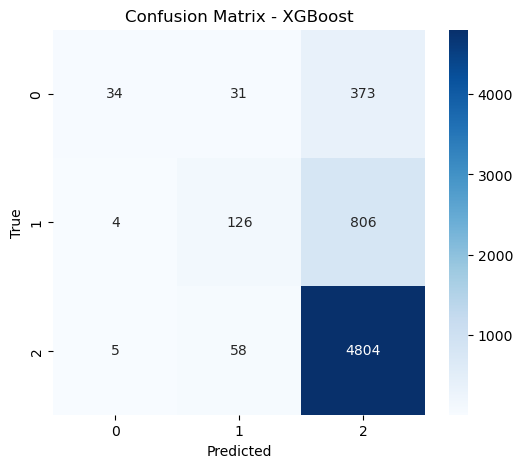


Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.08      0.14       438
           1       0.59      0.13      0.22       936
           2       0.80      0.99      0.89      4867

    accuracy                           0.80      6241
   macro avg       0.73      0.40      0.42      6241
weighted avg       0.77      0.80      0.73      6241



In [262]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Full classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


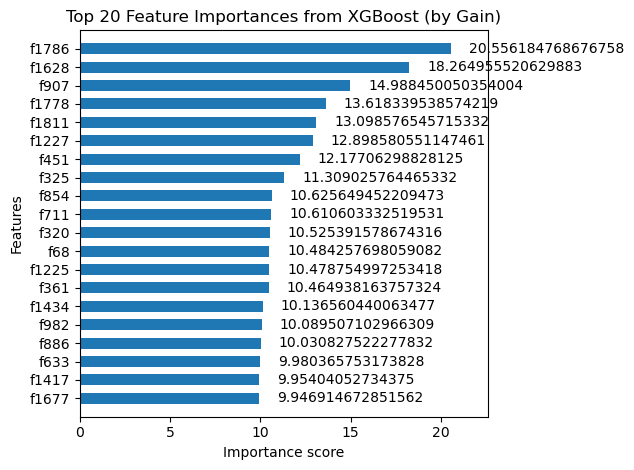

In [258]:
import matplotlib.pyplot as plt

xgb.plot_importance(
    xgb_model,
    max_num_features=20,
    importance_type='gain',  
    height=0.6,
    grid=False
)

plt.title('Top 20 Feature Importances from XGBoost (by Gain)')
plt.tight_layout()
plt.show()


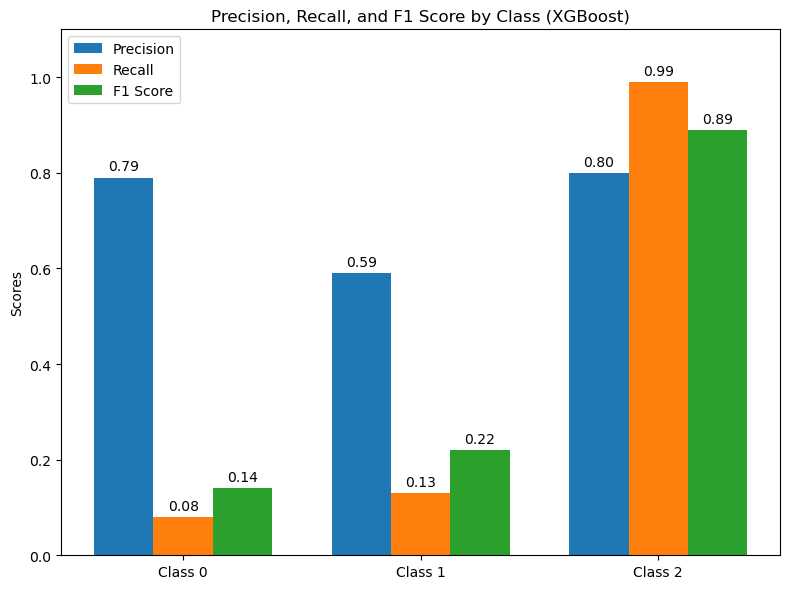

In [268]:
import matplotlib.pyplot as plt
import numpy as np

# Precision, Recall, F1-score for each class from classification report
classes = ['Class 0', 'Class 1', 'Class 2']
precision = [0.79, 0.59, 0.80]
recall = [0.08, 0.13, 0.99]
f1_score = [0.14, 0.22, 0.89]

x = np.arange(len(classes))  # the label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Add labels and title
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score by Class (XGBoost)')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1.1)
ax.legend()

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


In [272]:
import shap
import numpy as np
import pandas as pd

# If X_train is still a NumPy array, convert it to DataFrame with proper column names
if isinstance(X_train, np.ndarray):
    feature_names = [f'f{i}' for i in range(X_train.shape[1])]
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
else:
    X_train_df = X_train.copy()

# Create the SHAP explainer for the trained model
explainer = shap.Explainer(xgb_model, X_train_df)

# Get SHAP values
shap_values = explainer(X_train_df)


100%|===================| 74837/74880 [15:07<00:00]        

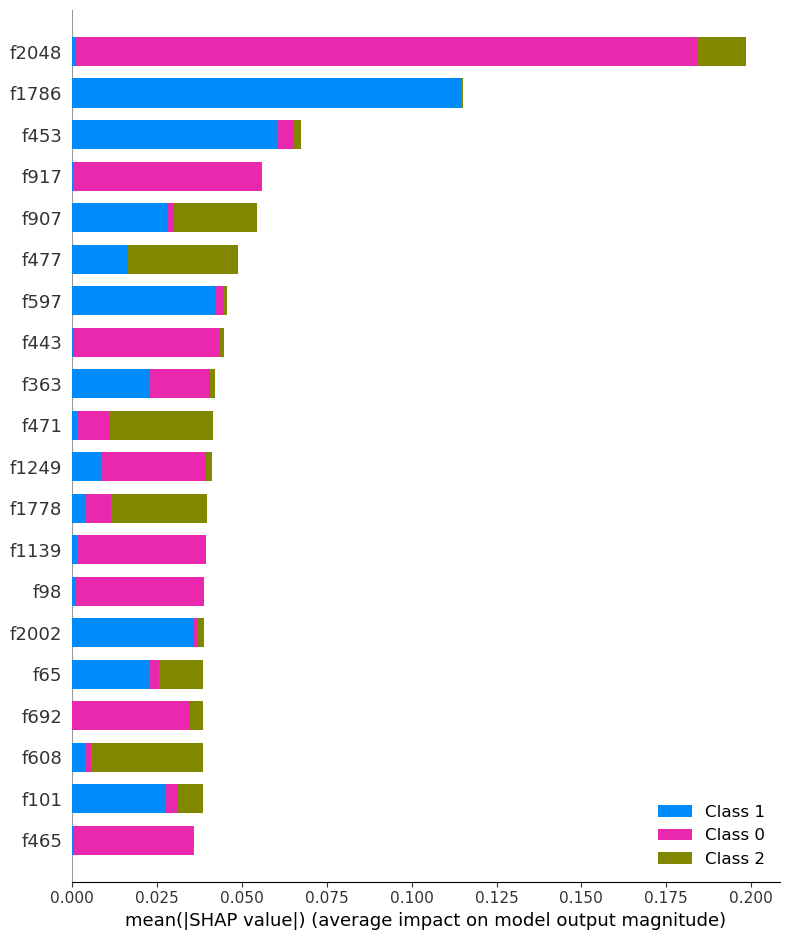

In [274]:
shap.summary_plot(shap_values, X_train_df, max_display=20)


C:\Users\karth\AppData\Local\Temp\ipykernel_6988\4160249142.py:45: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



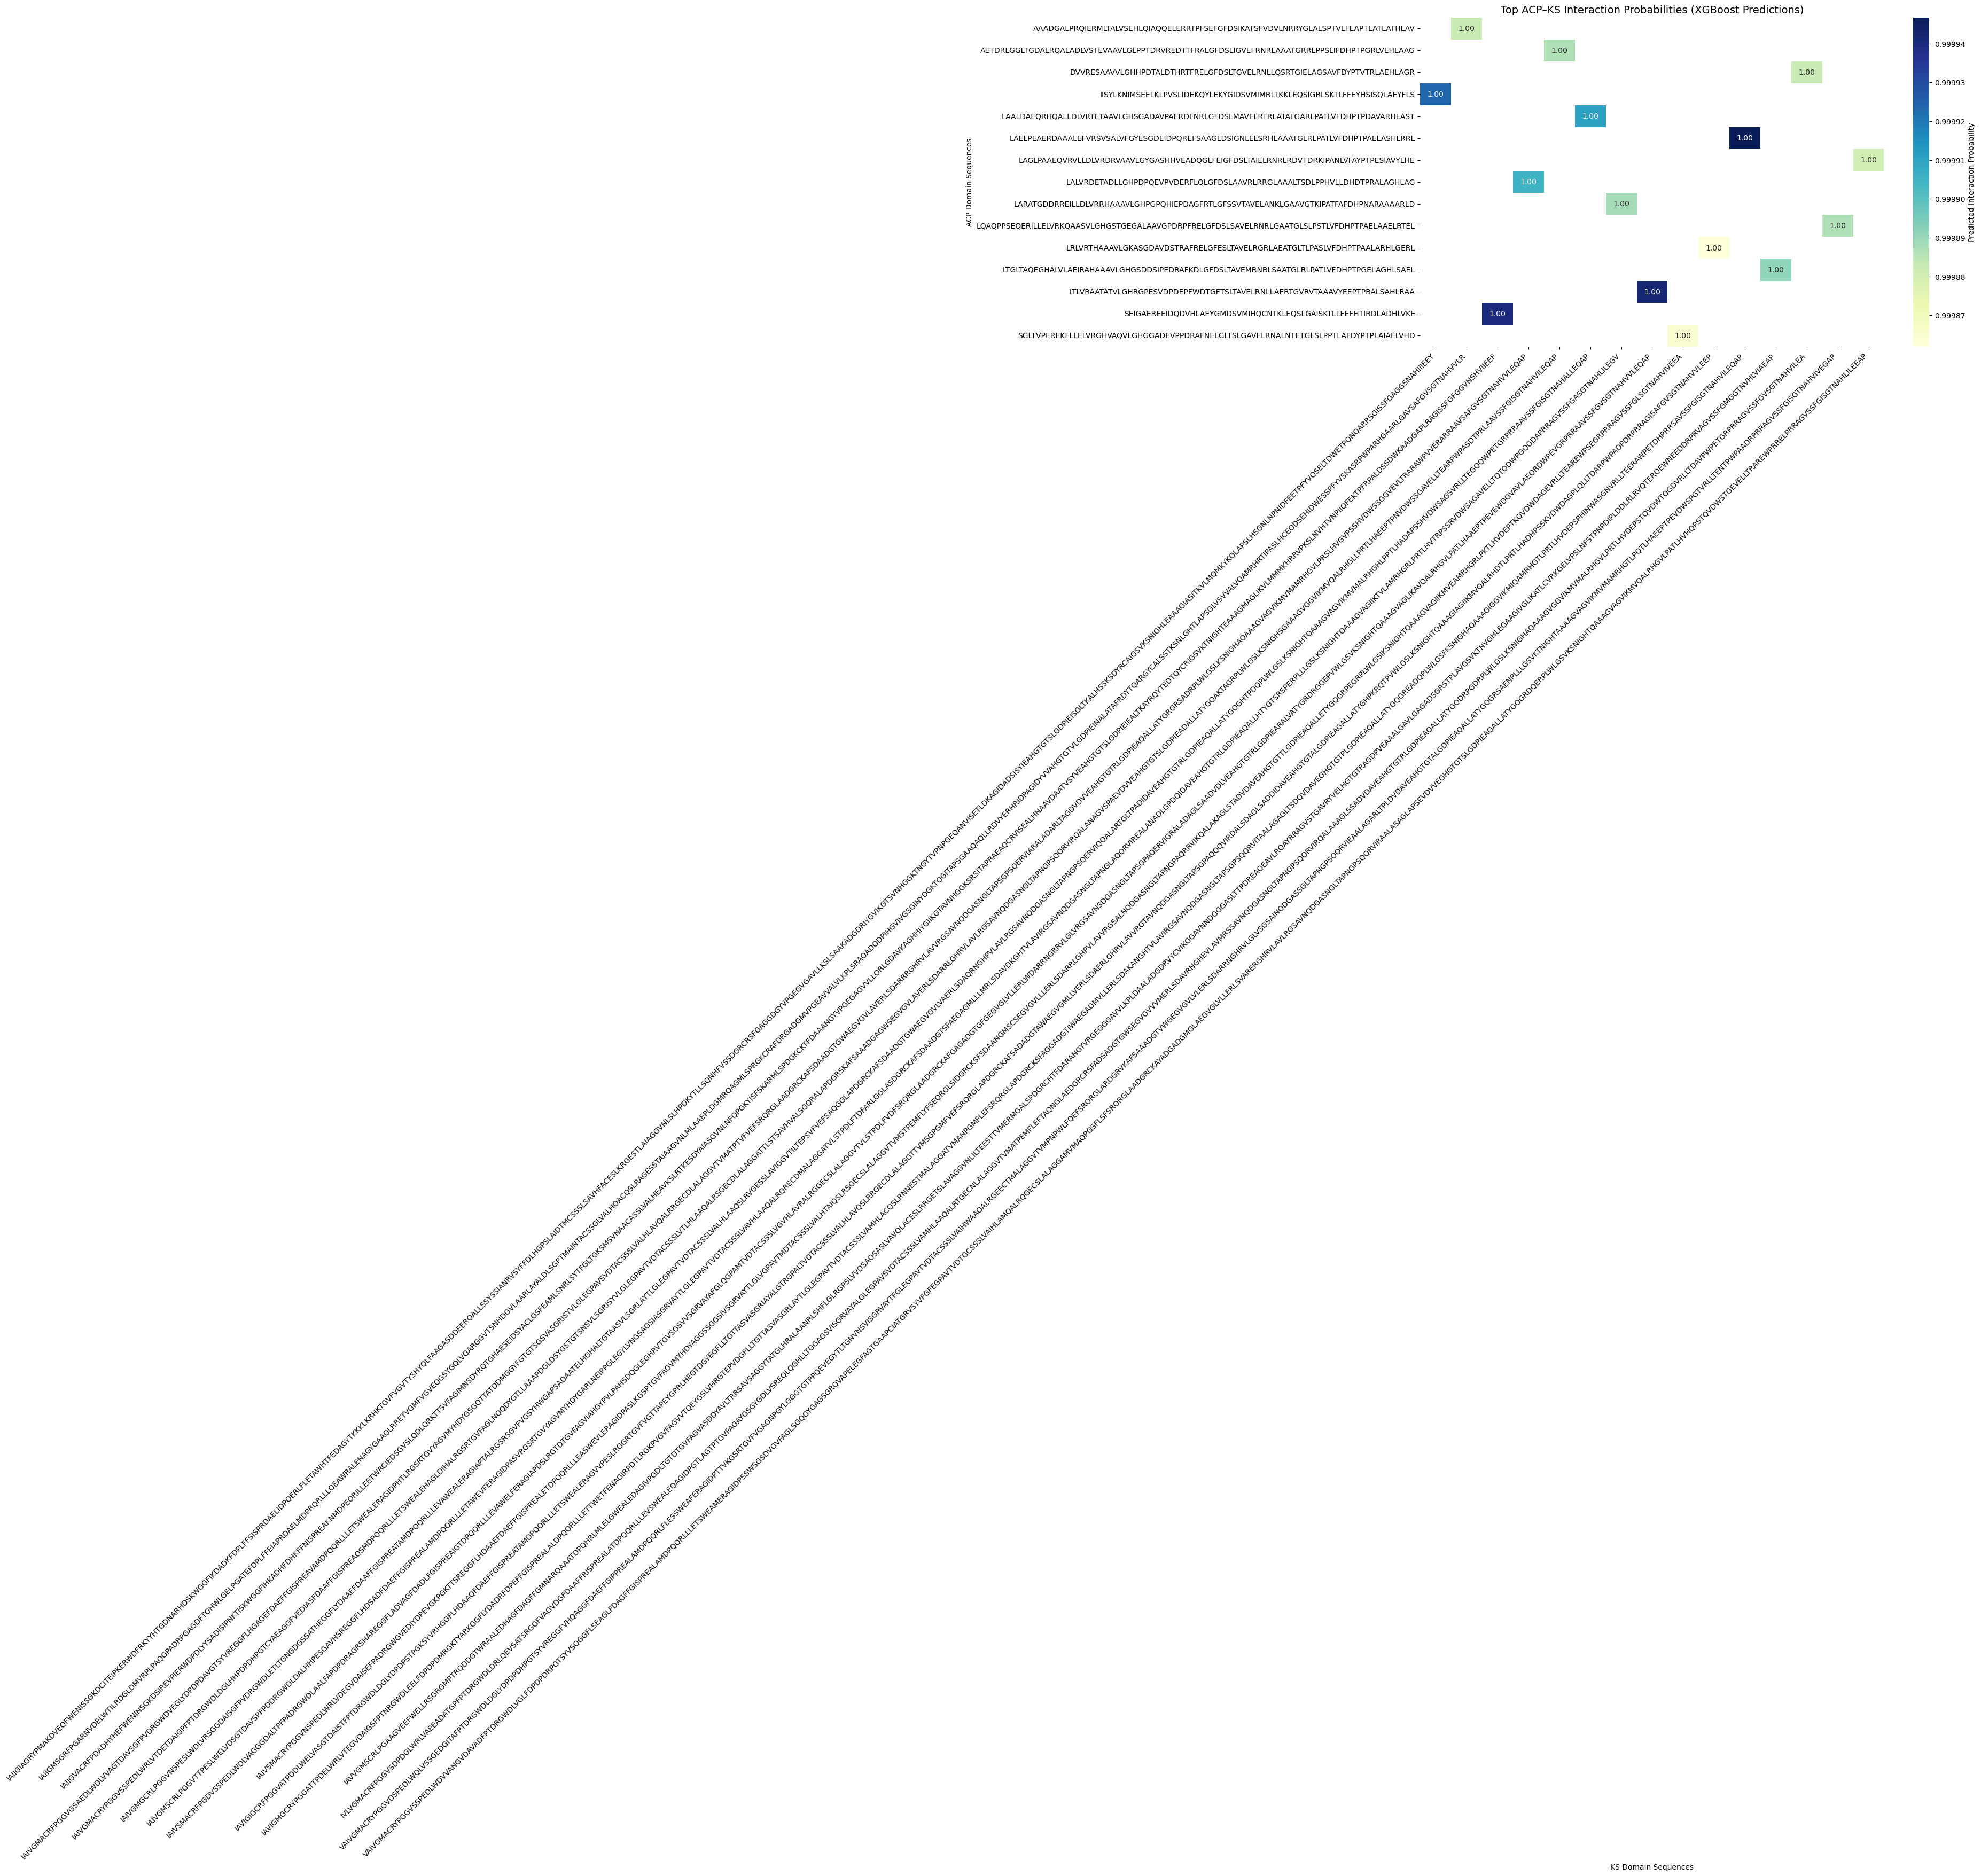

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get predicted probabilities for each class (from trained XGBoost model)
y_probs = xgb_model.predict_proba(X_test)

# Ensure X_test is a DataFrame and get proper indices
if isinstance(X_test, np.ndarray):
    X_test_df = pd.DataFrame(X_test)
else:
    X_test_df = X_test.copy()

# Align indices between X_test and merged_df
test_indices = X_test_df.index

# Create a dataframe for visualization
results_df = pd.DataFrame({
    'BGC_ID': merged_df.iloc[test_indices]['BGC ID'].values,
    'ACP_Sequence': merged_df.iloc[test_indices]['ACP Sequence'].values,
    'KS_Sequence': merged_df.iloc[test_indices]['KS Sequence'].values,
    'True_Label': y_test,
    'Pred_Label': np.argmax(y_probs, axis=1),
    'Interaction_Prob': y_probs[:, 2]  # Class 2 = interacting
})

# Get top 15 most confident predictions for visualization
top_interactions = results_df.sort_values(by='Interaction_Prob', ascending=False).head(15)

# Pivot table for heatmap: ACPs vs KSs → Interaction probability
heatmap_df = top_interactions.pivot_table(
    index='ACP_Sequence', 
    columns='KS_Sequence', 
    values='Interaction_Prob'
)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Predicted Interaction Probability'})
plt.title("Top ACP–KS Interaction Probabilities (XGBoost Predictions)", fontsize=14)
plt.xlabel("KS Domain Sequences")
plt.ylabel("ACP Domain Sequences")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


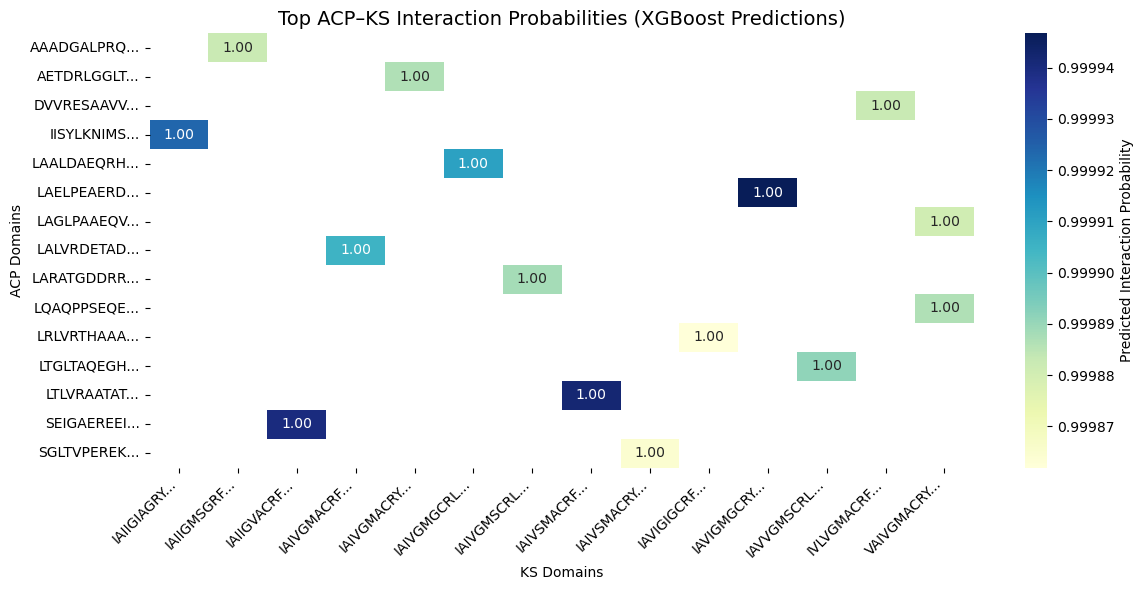

In [298]:
import seaborn as sns
import matplotlib.pyplot as plt

# Shorten sequence labels for better visualization
top_interactions['ACP_Label'] = top_interactions['ACP_Sequence'].str[:10] + "..."
top_interactions['KS_Label'] = top_interactions['KS_Sequence'].str[:10] + "..."

# Create a pivot table for heatmap
heatmap_df = top_interactions.pivot_table(
    index='ACP_Label',
    columns='KS_Label',
    values='Interaction_Prob'
)

# Plot heatmap with adjusted size and annotations
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Predicted Interaction Probability'}
)

plt.title("Top ACP–KS Interaction Probabilities (XGBoost Predictions)", fontsize=14)
plt.xlabel("KS Domains")
plt.ylabel("ACP Domains")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


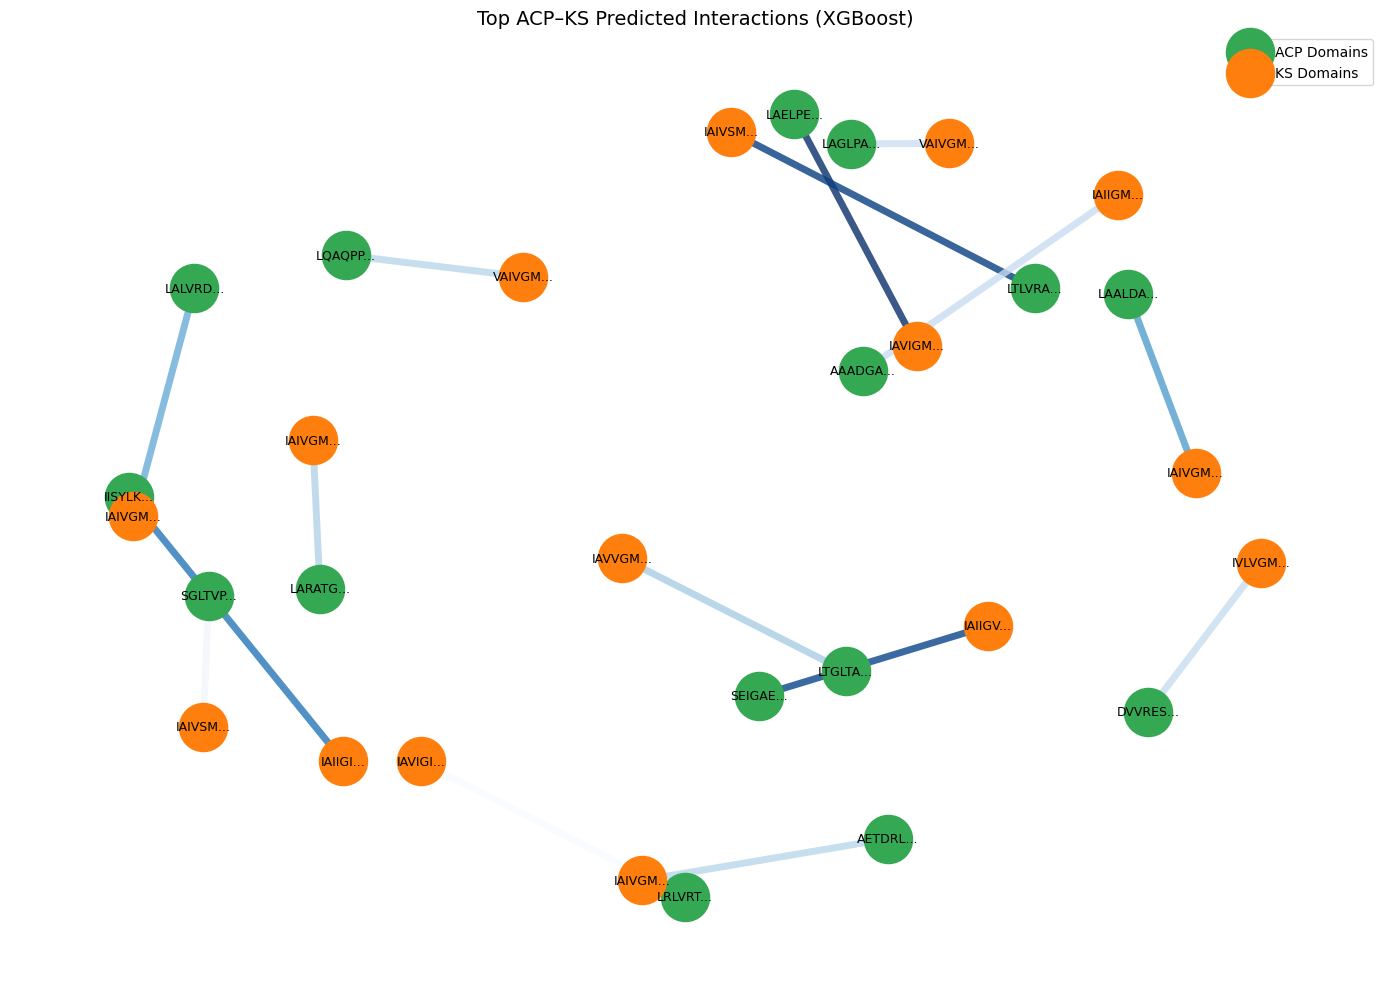

In [300]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Prepare top 15 ACP-KS interactions ---
# Assuming results_df contains: ['ACP_Sequence', 'KS_Sequence', 'Interaction_Prob']
top_pairs = results_df.sort_values(by="Interaction_Prob", ascending=False).head(15)

# --- Step 2: Build graph ---
G = nx.Graph()

# Add nodes: ACP (green) and KS (orange)
for acp in top_pairs["ACP_Sequence"].unique():
    G.add_node(acp, type="ACP")
for ks in top_pairs["KS_Sequence"].unique():
    G.add_node(ks, type="KS")

# Add edges with weights (probabilities)
for _, row in top_pairs.iterrows():
    G.add_edge(row["ACP_Sequence"], row["KS_Sequence"], weight=row["Interaction_Prob"])

# --- Step 3: Visualize ---
plt.figure(figsize=(14, 10))

# Get positions using spring layout for aesthetics
pos = nx.spring_layout(G, k=0.8, seed=42)

# Separate ACP and KS nodes
acp_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'ACP']
ks_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'KS']

# Draw ACP nodes (green)
nx.draw_networkx_nodes(G, pos, nodelist=acp_nodes, node_color="#34a853", node_size=1200, label="ACP Domains")
# Draw KS nodes (orange)
nx.draw_networkx_nodes(G, pos, nodelist=ks_nodes, node_color="#ff7f0e", node_size=1200, label="KS Domains")

# Draw edges with width proportional to interaction probability
edges = G.edges(data=True)
nx.draw_networkx_edges(
    G, pos,
    edgelist=edges,
    width=[d["weight"] * 5 for (_, _, d) in edges],  # Scale edge thickness
    edge_color=[d["weight"] for (_, _, d) in edges],
    edge_cmap=plt.cm.Blues,
    alpha=0.8
)

# Draw labels for nodes (show only first 6 letters for neatness)
labels = {n: n[:6] + "..." for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_color="black")

# Title, legend, and layout adjustments
plt.title("Top ACP–KS Predicted Interactions (XGBoost)", fontsize=14)
plt.legend(scatterpoints=1, fontsize=10)
plt.axis("off")
plt.tight_layout()
plt.show()


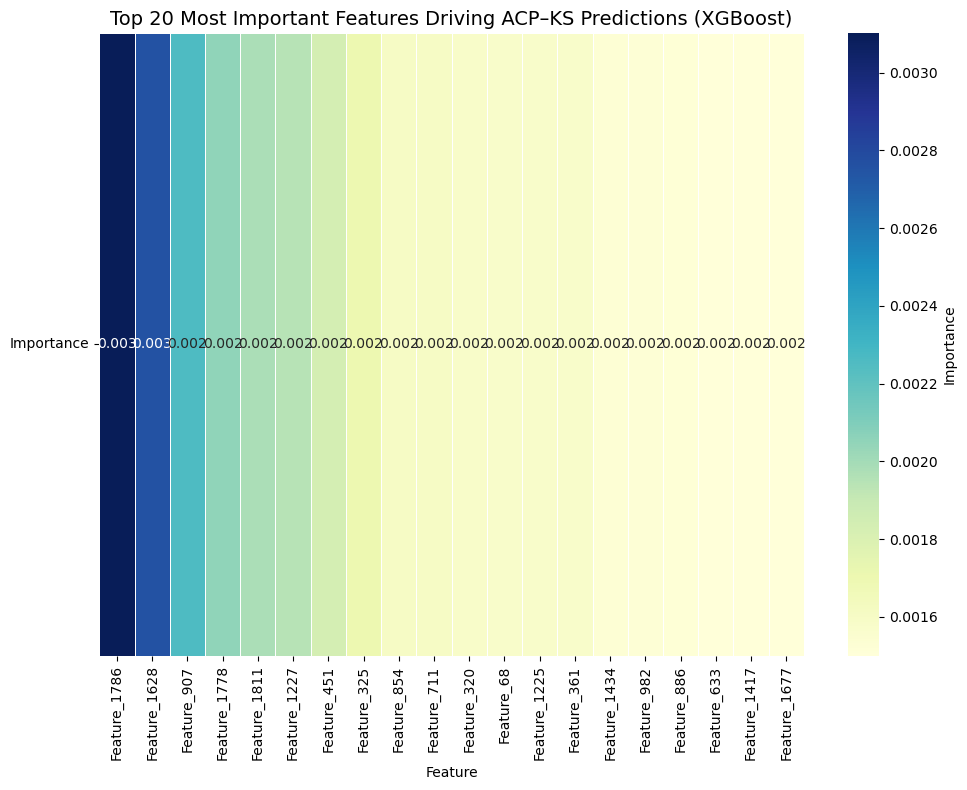

In [308]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Get feature importances from XGBoost
feature_importances = xgb_model.feature_importances_

# If X_train is a NumPy array, create placeholder names
if isinstance(X_train, np.ndarray):
    feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]
else:
    feature_names = X_train.columns

# Create a dataframe for feature importances
feature_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Select top 20 features
top_features = feature_df.head(20)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    top_features.set_index("Feature").T,
    cmap="YlGnBu",
    annot=True,
    fmt=".3f",
    cbar_kws={'label': 'Importance'},
    linewidths=0.5
)

plt.title("Top 20 Most Important Features Driving ACP–KS Predictions (XGBoost)", fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [310]:
print(type(X_train))
print(X_train.shape)
if hasattr(X_train, "columns"):
    print(X_train.columns.tolist()[:30])  # show first 30 columns


<class 'numpy.ndarray'>
(24960, 2049)


In [312]:
print(merged_df.shape)
print(merged_df.columns.tolist()[:30])


(31201, 2063)
['BGC ID', 'ACP Gene', 'ACP Module', 'ACP Sequence', 'KS Gene', 'KS Module', 'KS Sequence', 'Label', 'acp_emb', 'ks_emb', 'final_features', 'binary_label', 'cosine_sim', 'pairwise_features', 'ACP_0', 'ACP_1', 'ACP_2', 'ACP_3', 'ACP_4', 'ACP_5', 'ACP_6', 'ACP_7', 'ACP_8', 'ACP_9', 'ACP_10', 'ACP_11', 'ACP_12', 'ACP_13', 'ACP_14', 'ACP_15']


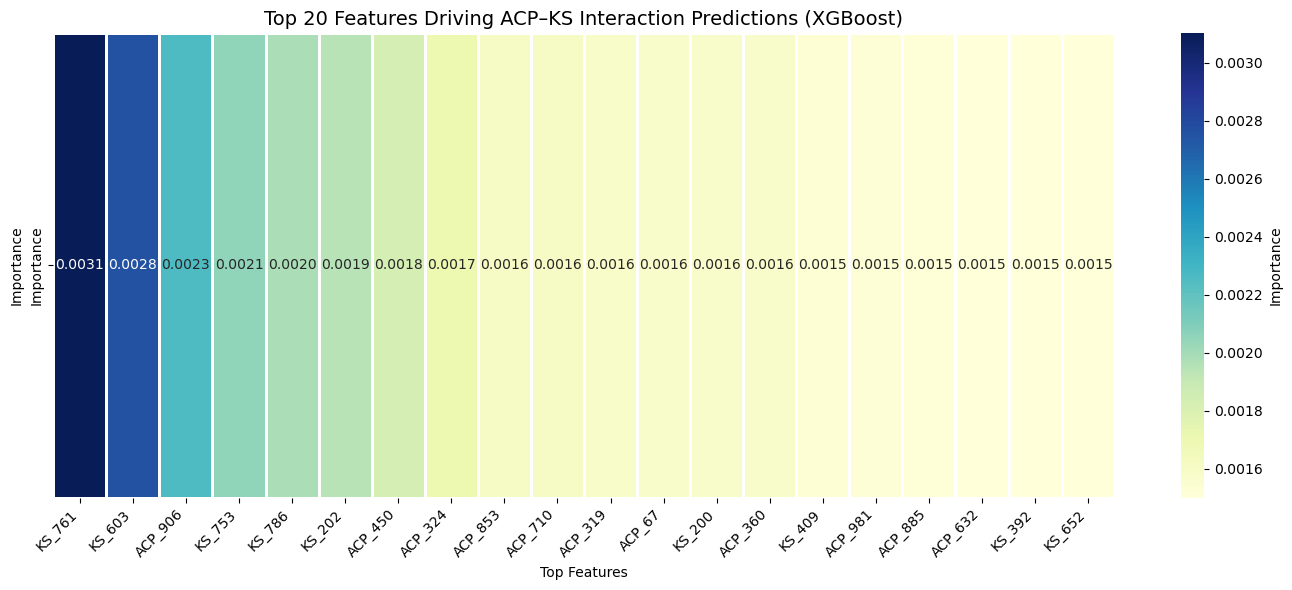

      Feature  Importance
1786   KS_761    0.003101
1628   KS_603    0.002756
907   ACP_906    0.002261
1778   KS_753    0.002055
1811   KS_786    0.001976
1227   KS_202    0.001946
451   ACP_450    0.001837
325   ACP_324    0.001706
854   ACP_853    0.001603
711   ACP_710    0.001601
320   ACP_319    0.001588
68     ACP_67    0.001582
1225   KS_200    0.001581
361   ACP_360    0.001579
1434   KS_409    0.001529
982   ACP_981    0.001522
886   ACP_885    0.001513
633   ACP_632    0.001506
1417   KS_392    0.001502
1677   KS_652    0.001501


In [314]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Build feature names list
acp_features = [f"ACP_{i}" for i in range(1024)]
ks_features = [f"KS_{i}" for i in range(1024)]
extra_features = ["cosine_sim"]
feature_names = extra_features + acp_features + ks_features  # total = 2049

# Create dataframe with real names
feature_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False).head(20)

# Journal-style heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    feature_df.set_index("Feature").T,
    cmap="YlGnBu",
    annot=True,
    fmt=".4f",
    linewidths=1,
    cbar_kws={'label': 'Importance'}
)

plt.title("Top 20 Features Driving ACP–KS Interaction Predictions (XGBoost)", fontsize=14)
plt.xlabel("Top Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Print top 20 important features
print(feature_df)


In [322]:
print(df.columns.tolist())


['BGC ID', 'Gene', 'Module', 'Domain', 'Location', 'AA Sequence', 'NT Sequence']


In [324]:
who


BertModel	 BertTokenizer	 Counter	 G	 LabelEncoder	 LogisticRegression	 PCA	 Patch	 ProteinAnalysis	 
RandomForestClassifier	 SMOTE	 TSNE	 X	 XGBClassifier	 X_df	 X_pca	 X_test	 X_test_df	 
X_train	 X_train_df	 X_train_res	 X_tsne	 accuracy	 accuracy_score	 acp	 acp_df	 acp_dim	 
acp_embeddings	 acp_features	 acp_names	 acp_nodes	 acp_row	 acp_seqs	 acps	 angle	 angle_acp	 
angle_ks	 autolabel	 ax	 bgc_id	 class_counts	 class_weights	 classes	 classification_report	 clf	 
cm	 combine_features	 compute_cosine_similarity	 concatenate	 confusion_matrix	 corr	 cosine_similarity	 counts	 dataframe_columns	 
dataframe_hash	 df	 df_binary	 dtypes_str	 edge_colors	 edges	 embed_sequence	 embedding_size	 explainer	 
extra_features	 extract_features	 extract_serine_features	 extract_serine_region	 f	 f1	 f1_score	 feat	 feature_cols	 
feature_df	 feature_importances	 feature_labels	 feature_names	 features_to_check	 fig	 file_path	 get_dataframes	 getpass	 
go	 gravy_0	 gravy_2	 group	 group0	 g

In [326]:
print(merged_df.columns)
print(merged_df.shape)
merged_df.head(3)


Index(['BGC ID', 'ACP Gene', 'ACP Module', 'ACP Sequence', 'KS Gene',
       'KS Module', 'KS Sequence', 'Label', 'acp_emb', 'ks_emb',
       ...
       'KS_1015', 'KS_1016', 'KS_1017', 'KS_1018', 'KS_1019', 'KS_1020',
       'KS_1021', 'KS_1022', 'KS_1023', 'cosine_similarity'],
      dtype='object', length=2063)
(31201, 2063)


BGC ID ACP Gene  ACP Module  \
0  BGC0000001.5    abyA3           0   
1  BGC0000001.5    abyA3           0   
2  BGC0000001.5    abyA3           0   

                                        ACP Sequence KS Gene  KS Module  \
0  FVTLVRDELGLPIEESDLDRHLDDVAGWDSVHLLALCSALERATGR...   abyB1          1   
1  FVTLVRDELGLPIEESDLDRHLDDVAGWDSVHLLALCSALERATGR...   abyB1          2   
2  FVTLVRDELGLPIEESDLDRHLDDVAGWDSVHLLALCSALERATGR...   abyB1          3   

                                         KS Sequence  Label  \
0  VAVVGLACRLPGAADPEAFWALLRDGREAITDPPASRRDPDGRARR...      2   
1  VAVIGMACRYPGGVGSPDDLWQLVRDGRDATGPFPTDRGWDLDALY...      2   
2  IAIVGMACRYPGGVSSPEDLWRLVADGVDAIGEFPTDRGWDLGRLY...      2   

                                             acp_emb  \
0  [-0.017117193, -2.3558736e-05, -0.018606469, -...   
1  [-0.017117193, -2.3558736e-05, -0.018606469, -...   
2  [-0.017117193, -2.3558736e-05, -0.018606469, -...   

                                              ks_emb  ...   KS_1015   KS_1016  \
0  [-0.034511644, -0.0045488663, 0.0014059874, -0...  ...  0.019957 -0.002674   
1  [-0.03393836, 0.002552823, -0.021368353, -0.03...  ...  0.046414  0.006173   
2  [-0.012034713, 0.02489423, -0.016638005, -0.03...  ...  0.058996  0.014387   

    KS_1017   KS_1018   KS_1019   KS_1020   KS_1021   KS_1022   KS_1023  \
0  0.001256 -0.036251  0.011982 -0.073991  0.009573 -0.025394 -0.023490   
1  0.000627 -0.039036  0.029676 -0.091770  0.008615 -0.017415 -0.025857   
2 -0.004256 -0.039519  0.026433 -0.073737  0.005769 -0.015088 -0.022795   

   cosine_similarity  
0           0.937048  
1           0.863861  
2           0.851223  

[3 rows x 2063 columns]

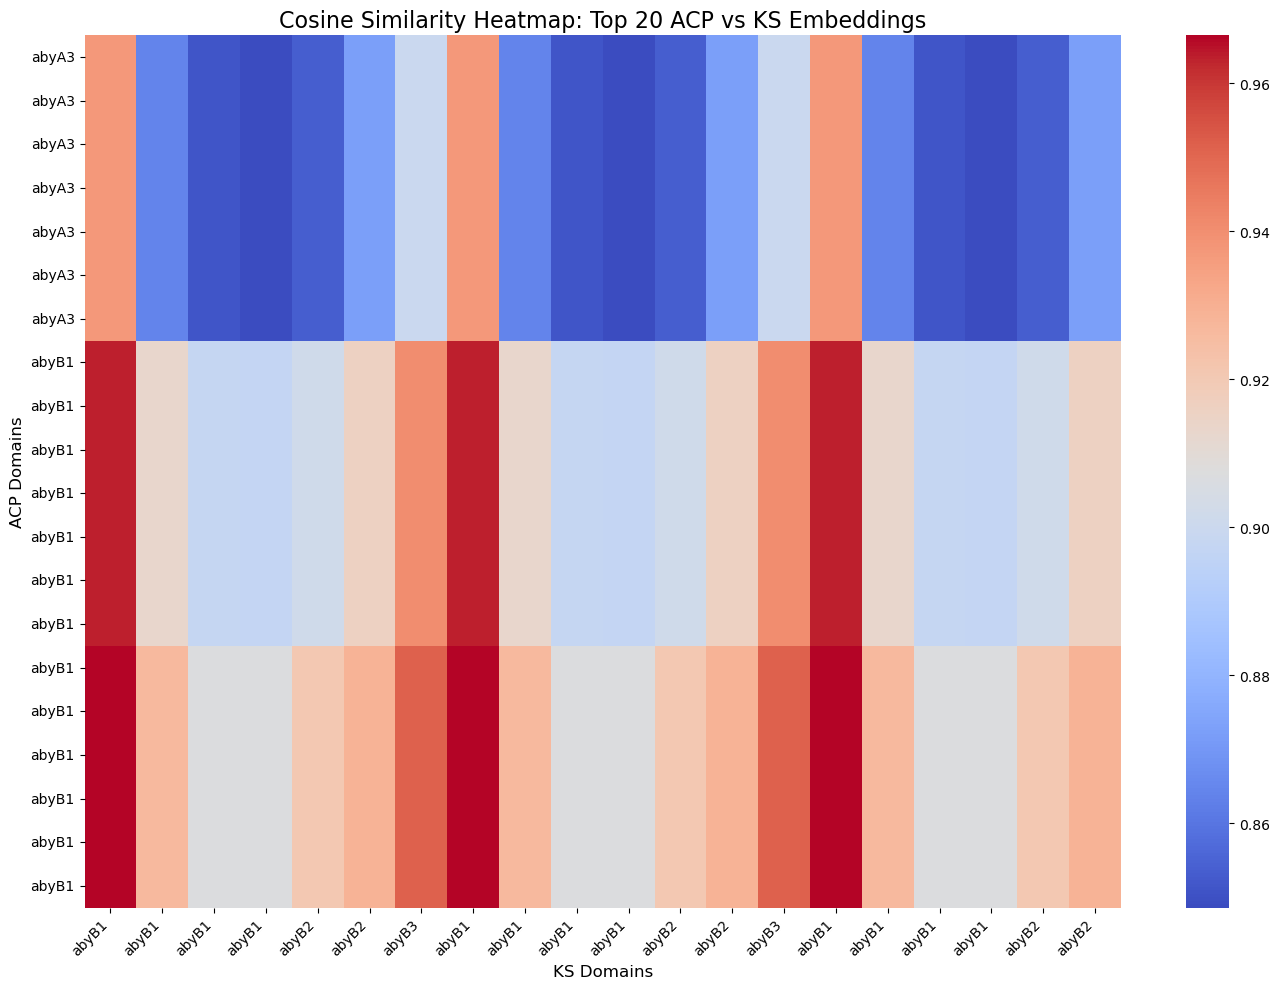

In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Extract embeddings from merged_df
acp_embeddings = np.vstack(merged_df['acp_emb'].values)
ks_embeddings = np.vstack(merged_df['ks_emb'].values)

# Step 2: Compute cosine similarity matrix between ACPs and KSs
similarity_matrix = cosine_similarity(acp_embeddings, ks_embeddings)

# Step 3: Limit to top 20 ACPs & KSs for readability
acp_labels = merged_df['ACP Gene'].head(20).tolist()
ks_labels = merged_df['KS Gene'].head(20).tolist()
similarity_subset = similarity_matrix[:20, :20]

# Step 4: Create the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(similarity_subset, cmap="coolwarm", annot=False, xticklabels=ks_labels, yticklabels=acp_labels)

# Titles & labels
plt.title("Cosine Similarity Heatmap: Top 20 ACP vs KS Embeddings", fontsize=16)
plt.xlabel("KS Domains", fontsize=12)
plt.ylabel("ACP Domains", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


<Figure size 1200x1000 with 0 Axes>

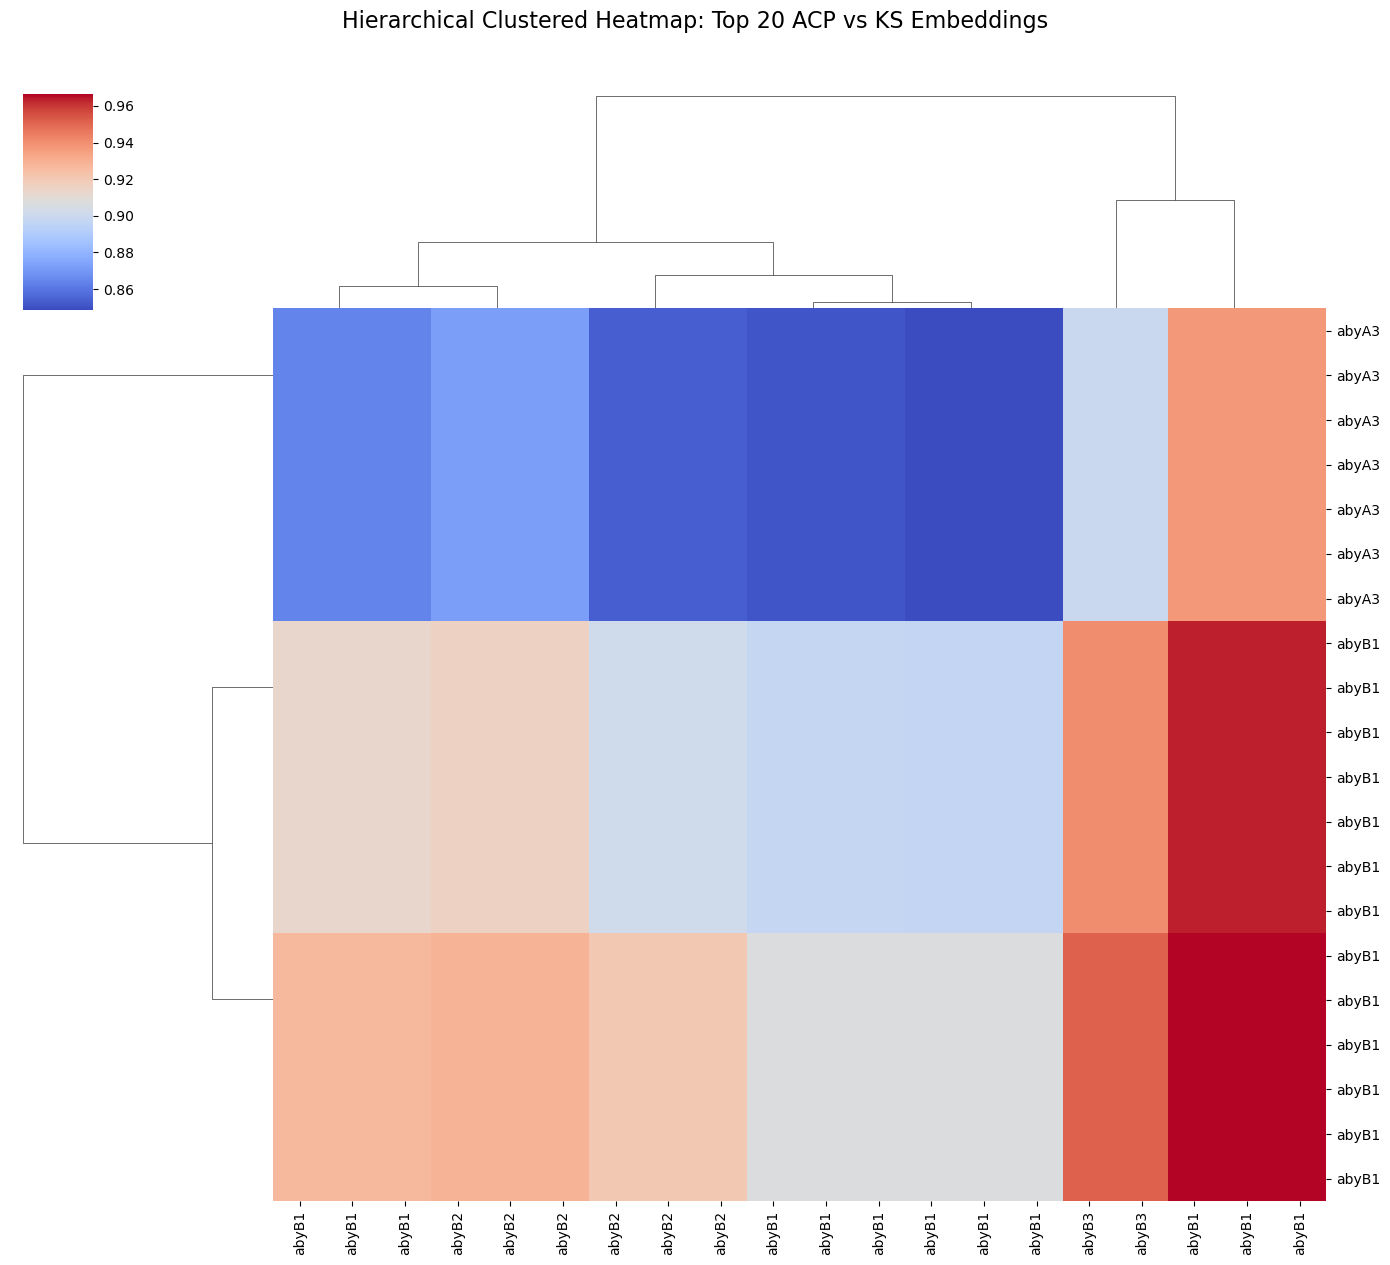

In [330]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Use the similarity matrix we already computed
similarity_subset = similarity_matrix[:20, :20]

# Step 2: Create a clustered heatmap
plt.figure(figsize=(12, 10))
sns.clustermap(
    similarity_subset,
    cmap="coolwarm",
    xticklabels=ks_labels,
    yticklabels=acp_labels,
    col_cluster=True,
    row_cluster=True,
    figsize=(14, 12),
    dendrogram_ratio=0.2,
    cbar_pos=(0.02, 0.8, 0.05, 0.18)
)

plt.suptitle("Hierarchical Clustered Heatmap: Top 20 ACP vs KS Embeddings", y=1.05, fontsize=16)
plt.show()
